## Clothing Size Recommendation Modeling with Keras 

More than ever retailers are taking their businesses online in order to stay competitive against e-commerces like Amazon and Etsy. Recent data shows that 2020 has been a great impetus for online shopping and it's here to stay. For clothing retailers looking to take their presence online or for existing clothing e-commerces having a strong clothing size recommmender can great benefit the business. A few of these benefits include: build customer loyalty, reduce cost, and increase sales. 

In this notebook, I take data from Rishabh Misra's dataset called "Clothing Fit Dataset for Size Recommendation" and make a model that will recommend the best clothing size. The dataset include data from two different e-commerce, Mod Cloth and Rent the Runway. I use only the Mod Cloth dataset to build out a Deep Learning model using Keras. My model uses body measurements of customers as input and provides a clothing size output. 

Dataset Citation: Rishabh Misra, Mengting Wan, Julian McAuley "Decomposing Fit Semantics for Product Size Recommendation in Metric Spaces". RecSys, 2018.


### Notebook Content:
- Import Data 
- Clean Data
- Exploratory Data Analysis
- Prepare Model
- Build Model 
- Summary

In [468]:
import json 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import seaborn as sns
import keras
from keras.layers import Input, Embedding, Dot, Reshape, Dense
from keras.models import Model
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import KNNImputer
import warnings
warnings.filterwarnings("ignore")

### IMPORT DATA

In [469]:
df = pd.read_json('modcloth_final_data.json', lines=True)
df.head()

,item_id,waist,size,quality,cup size,hips,bra size,category,bust,height,user_name,length,fit,user_id,shoe size,shoe width,review_summary,review_text
0,123373,29.0,7,5.0,d,38.0,34.0,new,36,5ft 6in,Emily,just right,small,991571,NaN,NaN,NaN,NaN
1,123373,31.0,13,3.0,b,30.0,36.0,new,NaN,5ft 2in,sydneybraden2001,just right,small,587883,NaN,NaN,NaN,NaN
2,123373,30.0,7,2.0,b,NaN,32.0,new,NaN,5ft 7in,Ugggh,slightly long,small,395665,9.0,NaN,NaN,NaN
3,123373,NaN,21,5.0,dd/e,NaN,NaN,new,NaN,NaN,alexmeyer626,just right,fit,875643,NaN,NaN,NaN,NaN
4,123373,NaN,18,5.0,b,NaN,36.0,new,NaN,5ft 2in,dberrones1,slightly long,small,944840,NaN,NaN,NaN,NaN


### CLEAN DATA

In [470]:
df.shape
#82,790 observations and 18 features 

(82790, 18)

In [471]:
df.describe()

,item_id,waist,size,quality,hips,bra size,user_id,shoe size
count,82790.000000,2882.000000,82790.000000,82722.000000,56064.000000,76772.000000,82790.000000,27915.000000
mean,469325.229170,31.319223,12.661602,3.949058,40.358501,35.972125,498849.564718,8.145818
std,213999.803314,5.302849,8.271952,0.992783,5.827166,3.224907,286356.969459,1.336109
min,123373.000000,20.000000,0.000000,1.000000,30.000000,28.000000,6.000000,5.000000
25%,314980.000000,28.000000,8.000000,3.000000,36.000000,34.000000,252897.750000,7.000000
50%,454030.000000,30.000000,12.000000,4.000000,39.000000,36.000000,497913.500000,8.000000
75%,658440.000000,34.000000,15.000000,5.000000,43.000000,38.000000,744745.250000,9.000000
max,807722.000000,50.000000,38.000000,5.000000,60.000000,48.000000,999972.000000,38.000000


In [472]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82790 entries, 0 to 82789
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   item_id         82790 non-null  int64  
 1   waist           2882 non-null   float64
 2   size            82790 non-null  int64  
 3   quality         82722 non-null  float64
 4   cup size        76535 non-null  object 
 5   hips            56064 non-null  float64
 6   bra size        76772 non-null  float64
 7   category        82790 non-null  object 
 8   bust            11854 non-null  object 
 9   height          81683 non-null  object 
 10  user_name       82790 non-null  object 
 11  length          82755 non-null  object 
 12  fit             82790 non-null  object 
 13  user_id         82790 non-null  int64  
 14  shoe size       27915 non-null  float64
 15  shoe width      18607 non-null  object 
 16  review_summary  76065 non-null  object 
 17  review_text     76065 non-null 

Datatypes:
- The dataset has a mix of data types including integer, float, and object. 
- Bust is a numeric value variable however the dtype listed is object. Height can be seen as the same, however it has ft. in it. 
- Height is given as feet and inches. Consider converting it into an easier number. 

I will convert values into float as main numeric datatype because we want to keep the accuracy of the data 
With the object values, encode it into a numeric value using one-hot encoding. 

Numeric variables: waist, size, quality, hips, bra size, bust, shoe size, shoe width

Categoric variables: quality, cup size, category, lenght, fit, review summary, review text

In [473]:
#percentage of null values
df.isnull().sum() * 100 / len(df)

item_id            0.000000
waist             96.518903
size               0.000000
quality            0.082136
cup size           7.555260
hips              32.281677
bra size           7.268994
category           0.000000
bust              85.681846
height             1.337118
user_name          0.000000
length             0.042276
fit                0.000000
user_id            0.000000
shoe size         66.282160
shoe width        77.525063
review_summary     8.122962
review_text        8.122962
dtype: float64

Missing values: 
- The largest missing values are of waist, hips, bust, shoe size, and shoe width. 
- The only variables with complete data are size, category, user_name, fit and user_id. 

Any features with less than 10% of missing values will be dropped, and the rest will be filled using imputation.

#### Outlier detection and treatment

In [474]:
df_copy = df.copy()

In [475]:
df_copy.drop(['item_id', 'user_id'], inplace=True, axis=1)

In [476]:
df_copy.describe()

,waist,size,quality,hips,bra size,shoe size
count,2882.000000,82790.000000,82722.000000,56064.000000,76772.000000,27915.000000
mean,31.319223,12.661602,3.949058,40.358501,35.972125,8.145818
std,5.302849,8.271952,0.992783,5.827166,3.224907,1.336109
min,20.000000,0.000000,1.000000,30.000000,28.000000,5.000000
25%,28.000000,8.000000,3.000000,36.000000,34.000000,7.000000
50%,30.000000,12.000000,4.000000,39.000000,36.000000,8.000000
75%,34.000000,15.000000,5.000000,43.000000,38.000000,9.000000
max,50.000000,38.000000,5.000000,60.000000,48.000000,38.000000


I'll drop variables item_id, user_id, and user_name from the dataframe since they're not relevant in determining a clothing size.

In [477]:
#drop variables 
df_copy.drop(['user_name'], inplace=True, axis=1)
#int into float64
df1 = df_copy.astype({"size":'float64'})  

In [478]:
#change height from ft and in to cm for numeric consistency 
def height_conv(ht):
  if ht.lower() != 'nan':
    ht = ht.replace('ft','').replace('in', '')
    h_ft = int(ht.split()[0])
    if len(ht.split()) > 1:
      h_inch = int(ht.split()[1])
    else:
      h_inch = 0
    h_inch += h_ft * 12
    h_cm = round(h_inch * 2.54, 1)
    return h_cm

df1.height = df1.height.astype(str).apply(height_conv)
df1.head()



,waist,size,quality,cup size,hips,bra size,category,bust,height,length,fit,shoe size,shoe width,review_summary,review_text
0,29.0,7.0,5.0,d,38.0,34.0,new,36,167.6,just right,small,NaN,NaN,NaN,NaN
1,31.0,13.0,3.0,b,30.0,36.0,new,NaN,157.5,just right,small,NaN,NaN,NaN,NaN
2,30.0,7.0,2.0,b,NaN,32.0,new,NaN,170.2,slightly long,small,9.0,NaN,NaN,NaN
3,NaN,21.0,5.0,dd/e,NaN,NaN,new,NaN,NaN,just right,fit,NaN,NaN,NaN,NaN
4,NaN,18.0,5.0,b,NaN,36.0,new,NaN,157.5,slightly long,small,NaN,NaN,NaN,NaN


Treat outliers by using Interquartile Range(IQR) method

In [479]:
def cap_data(df1):
    for col in df1.columns:
        if (((df1[col].dtype)=='float64')):
            percentiles = df1[col].quantile([0.25,0.75]).values
            df1[col][df1[col] <= percentiles[0]] = percentiles[0]
            df1[col][df1[col] >= percentiles[1]] = percentiles[1]
        else:
            df1[col]=df1[col]
    return df1

final_df=cap_data(df1)

In [480]:
final_df.describe()

,waist,size,quality,hips,bra size,height,shoe size
count,2882.000000,82790.000000,82722.000000,56064.000000,76772.000000,81683.000000,27915.000000
mean,30.647120,11.142227,4.043568,39.426406,35.730423,165.219120,8.071861
std,2.522658,3.041493,0.818712,2.864560,1.704380,4.151507,0.806897
min,28.000000,8.000000,3.000000,36.000000,34.000000,160.000000,7.000000
25%,28.000000,8.000000,3.000000,36.000000,34.000000,160.000000,7.000000
50%,30.000000,12.000000,4.000000,39.000000,36.000000,165.100000,8.000000
75%,34.000000,15.000000,5.000000,43.000000,38.000000,170.200000,9.000000
max,34.000000,15.000000,5.000000,43.000000,38.000000,170.200000,9.000000


#### Imputation for missing values 

In [481]:
imputer = KNNImputer(n_neighbors=5)

In [482]:
#df_knn_fillin = imputer.fit_transform(knn_fillin)
#this doesn't work because there is a string '37-39', need to pick one value for it 
final_df.bust[final_df.bust=='37-39'] = 37

In [483]:
knn_fillin = final_df[['waist', 'hips', 'bra size', 'bust', 'height', 'shoe size', 'quality']]

In [484]:
#try again
df_knn_fillin = imputer.fit_transform(knn_fillin)

In [485]:
imputations_fill = pd.DataFrame(data=df_knn_fillin, columns=['waist', 'hips', 'bra size', 'bust', 'height', 'shoe size', 'quality'])
imputations_fill

,waist,hips,bra size,bust,height,shoe size,quality
0,29.0,38.0,34.0,36.0,167.60,8.2,5.0
1,31.0,36.0,36.0,39.2,160.00,7.6,3.0
2,30.0,37.4,34.0,36.0,170.20,9.0,3.0
3,29.0,38.8,37.2,37.8,166.12,7.4,5.0
4,31.4,41.4,36.0,37.2,160.00,7.4,5.0
...,...,...,...,...,...,...,...
82785,32.4,40.8,36.0,42.6,170.20,8.5,4.0
82786,29.0,38.0,34.0,33.2,165.10,7.7,5.0
82787,28.4,36.0,34.0,33.6,162.60,8.0,5.0
82788,29.6,41.2,34.8,37.0,160.00,7.3,4.0


In [491]:
#delete existing columns and replace with concated imputed data
df_concat_num = df1.drop(['waist', 'hips', 'bra size', 'bust', 'height', 'shoe size', 'quality'], axis=1)

In [492]:
df_f = pd.concat([imputations_fill, df_concat_num, ], axis=1)

In [493]:
df_f.isnull().sum()

waist                 0
hips                  0
bra size              0
bust                  0
height                0
shoe size             0
quality               0
size                  0
cup size           6255
category              0
length               35
fit                   0
shoe width        64183
review_summary     6725
review_text        6725
dtype: int64

Some of the missing numeric variables are now filled with KNN imputations.

In [494]:
df_float = df_f.loc[:, df_f.dtypes == 'float64']

In [495]:
df_obj = df_f.loc[:, df_f.dtypes == 'object']

Change categorical variable by using ordinal encoding on cup size, length, fit and shoe width because in length, shoe width and fit, there is a relationship between the values, fit and size.

In [496]:
df_f['cup size'].unique()

array(['d', 'b', 'dd/e', 'c', 'ddd/f', 'dddd/g', 'i', 'a', nan, 'h', 'aa',
       'j', 'k'], dtype=object)

In [497]:
cup_dict = {'a':1, 'aa':2, 'b':3, 'c':4, 'd':5, 'dd/e':6, 'ddd/f':7, 'dddd/g':8, 'h':9, 'i':10, 'j':11, 'k':12}
df_f['cup size'] = df_f['cup size'].map(cup_dict)

In [498]:
df_f['length'].unique()

array(['just right', 'slightly long', 'very short', 'slightly short',
       'very long', nan], dtype=object)

In [499]:
len_dict = {'very short':1, 'slightly short':2, 'just right':3, 'slightly long':4, 'very long':5}
df_f['length'] = df_f['length'].map(len_dict)

In [500]:
df_f['shoe width'].unique()

array([nan, 'wide', 'average', 'narrow'], dtype=object)

In [501]:
shoe_dict = {'narrow':1, 'average':2, 'wide':3}
df_f['shoe width'] = df_f['shoe width'].map(shoe_dict)

In [502]:
df_f['fit'].unique()

array(['small', 'fit', 'large'], dtype=object)

In [503]:
fit_dict = {'small':1, 'fit':2, 'large':3}
df_f['fit'] = df_f['fit'].map(fit_dict)

Drop variables: Review text, Review summary, Category, and shoe width. I want to only include body size measurements in my model. Shoe width was dropped as it is less significant in determining clothing size. Review Text and Summary are better left for customers to interact with than adding them as inputs.

In [504]:
df_f.drop(['review_text', 'review_summary', 'category', 'shoe width'], inplace=True, axis=1)

In [505]:
df_f

,waist,hips,bra size,bust,height,shoe size,quality,size,cup size,length,fit
0,29.0,38.0,34.0,36.0,167.60,8.2,5.0,8.0,5.0,3.0,1
1,31.0,36.0,36.0,39.2,160.00,7.6,3.0,13.0,3.0,3.0,1
2,30.0,37.4,34.0,36.0,170.20,9.0,3.0,8.0,3.0,4.0,1
3,29.0,38.8,37.2,37.8,166.12,7.4,5.0,15.0,6.0,3.0,2
4,31.4,41.4,36.0,37.2,160.00,7.4,5.0,15.0,3.0,4.0,1
...,...,...,...,...,...,...,...,...,...,...,...
82785,32.4,40.8,36.0,42.6,170.20,8.5,4.0,8.0,3.0,3.0,2
82786,29.0,38.0,34.0,33.2,165.10,7.7,5.0,12.0,7.0,4.0,1
82787,28.4,36.0,34.0,33.6,162.60,8.0,5.0,12.0,8.0,3.0,2
82788,29.6,41.2,34.8,37.0,160.00,7.3,4.0,12.0,NaN,3.0,2


In [506]:
df_f['length'].unique()

array([ 3.,  4.,  1.,  2.,  5., nan])

In [507]:
DF = df_f.astype({"fit":'float64'})  

In [508]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82790 entries, 0 to 82789
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   waist      82790 non-null  float64
 1   hips       82790 non-null  float64
 2   bra size   82790 non-null  float64
 3   bust       82790 non-null  float64
 4   height     82790 non-null  float64
 5   shoe size  82790 non-null  float64
 6   quality    82790 non-null  float64
 7   size       82790 non-null  float64
 8   cup size   76535 non-null  float64
 9   length     82755 non-null  float64
 10  fit        82790 non-null  float64
dtypes: float64(11)
memory usage: 6.9 MB


### EXPLORATORY DATA ANALYSIS 

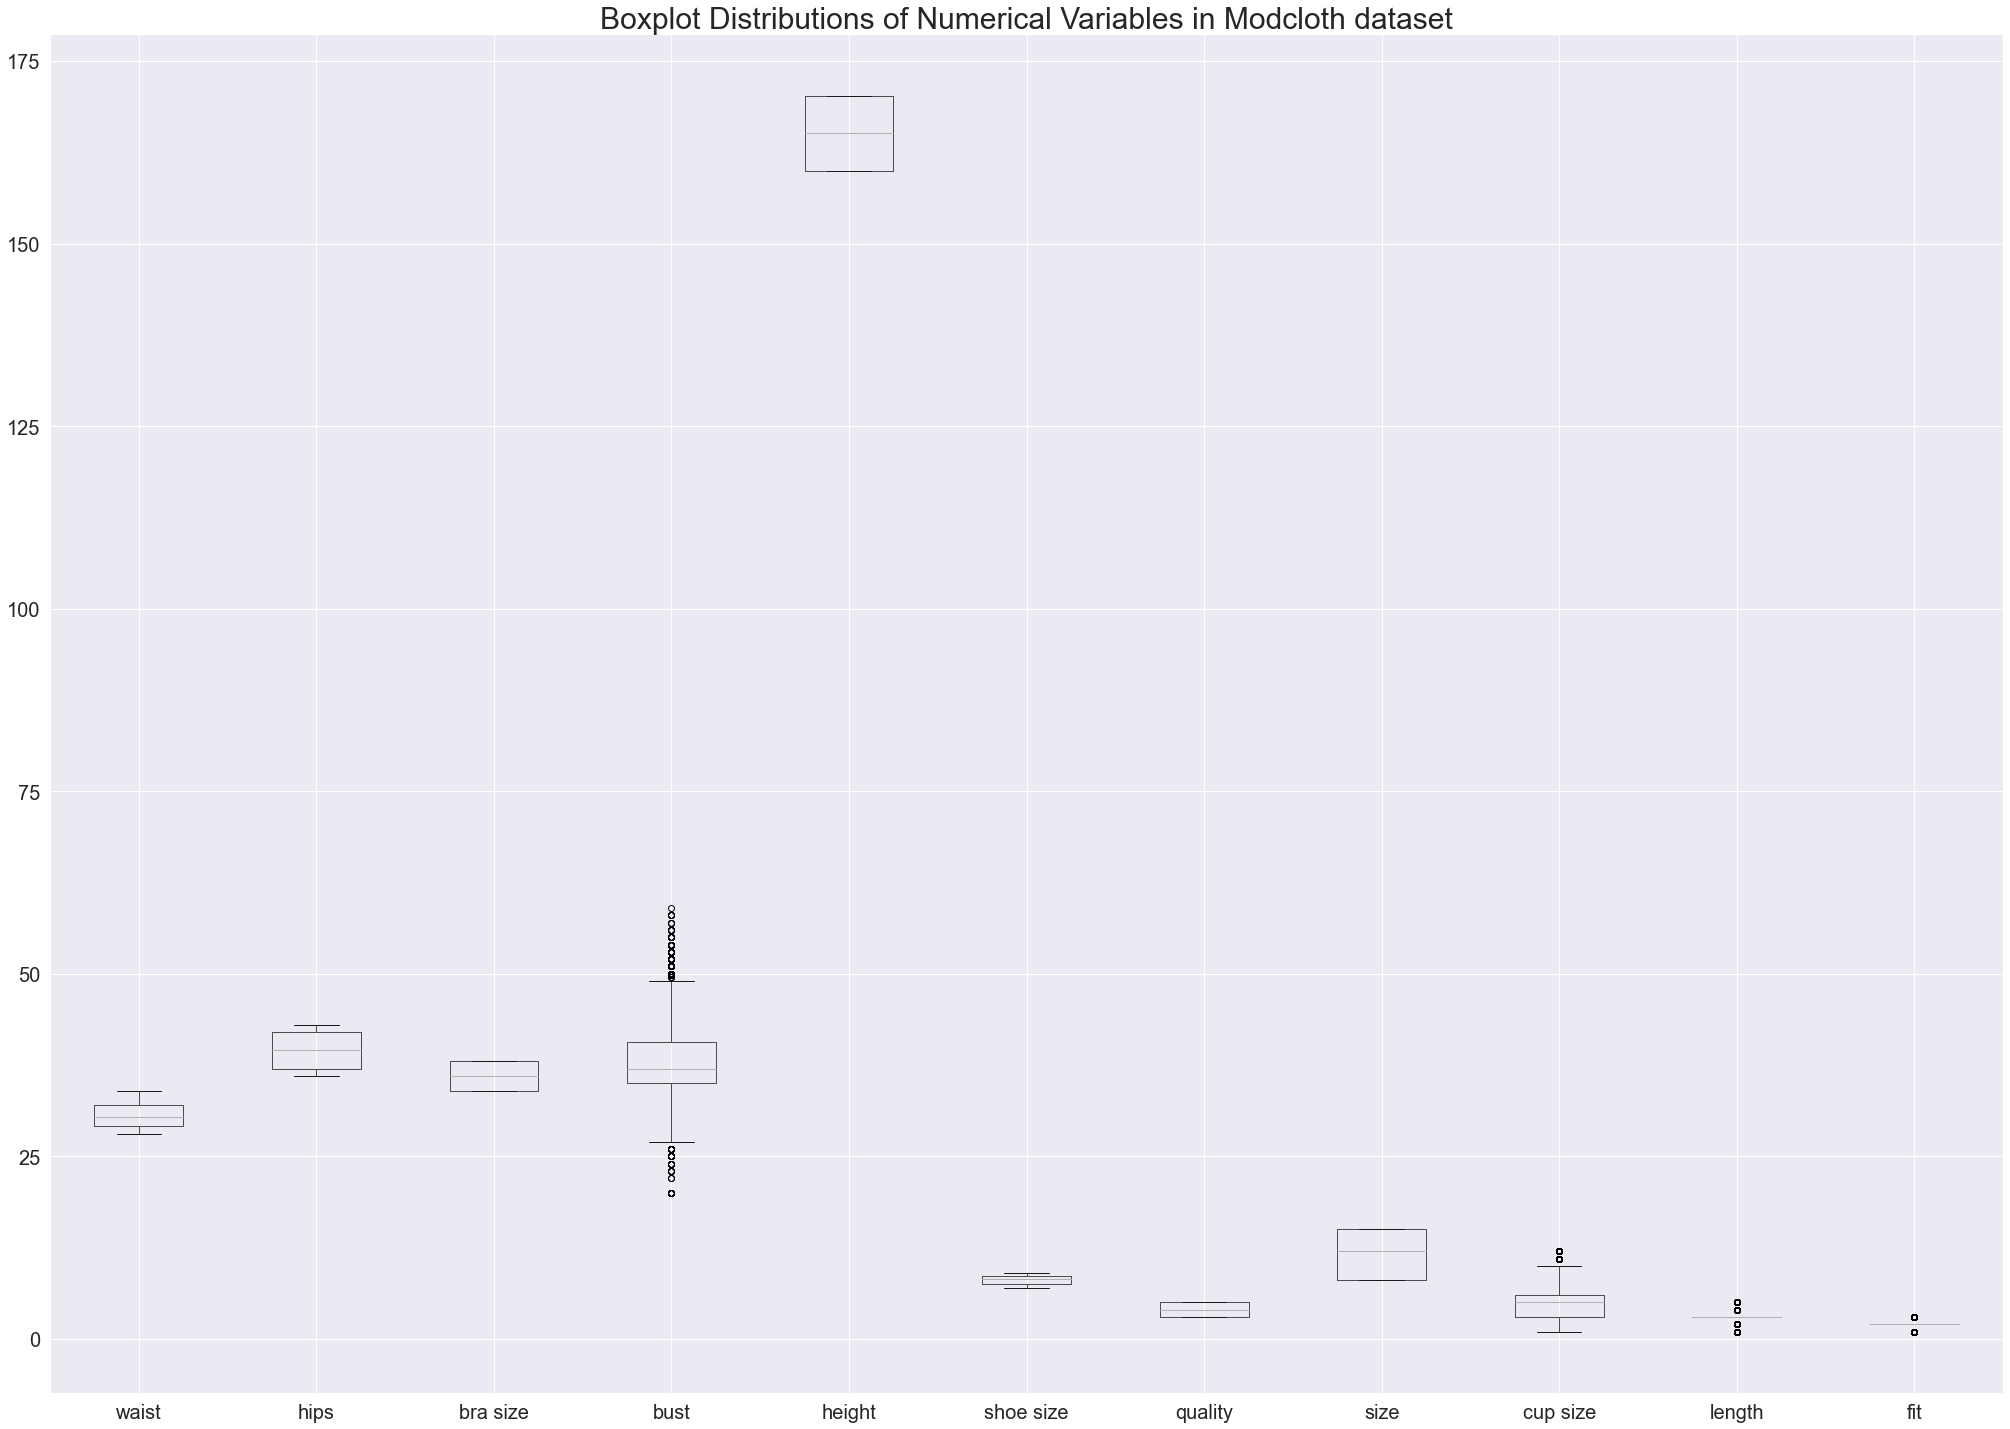

In [509]:
plt.figure(figsize=(35,25))
DF.boxplot()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("Boxplot Distributions of Numerical Variables in Modcloth dataset", fontsize=30)
plt.show()

Features that still have outliers after the interquartile treatment include bust, cup size, length, and fit. 

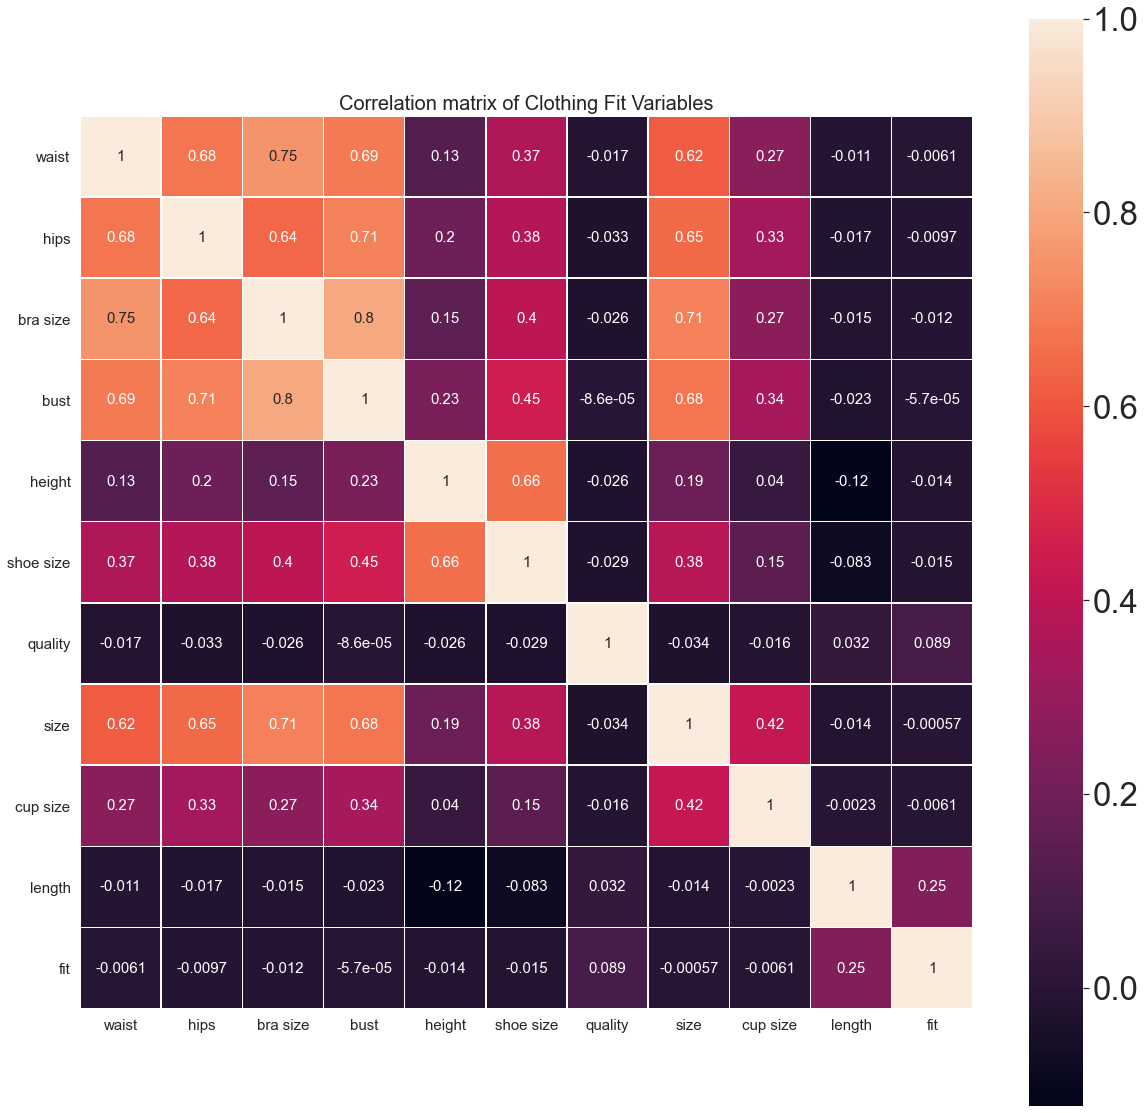

In [510]:
#Looking only at the correlation of fit variables
corrmat_df = DF.corr()
plt.figure(figsize=(20,20))

plt.subplot(1,1,1)
res = sns.heatmap(corrmat_df, square=True, annot=True, linewidths=.5, annot_kws={"size": 15})
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 15, rotation=0)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 15, rotation=0)
plt.title("Correlation matrix of Clothing Fit Variables", fontsize=20)

plt.show()

Based on the Boxplot and Correlation graphs, Bust and Bra Size are highly correlated. Between the two variables I will use Bra Size because it doesn't have outliers compared to Bust which has a lot. I will keep the outliers for the other variables: Lenght, Fit and Cup size, since there are only a few in each. 

<Figure size 432x288 with 0 Axes>

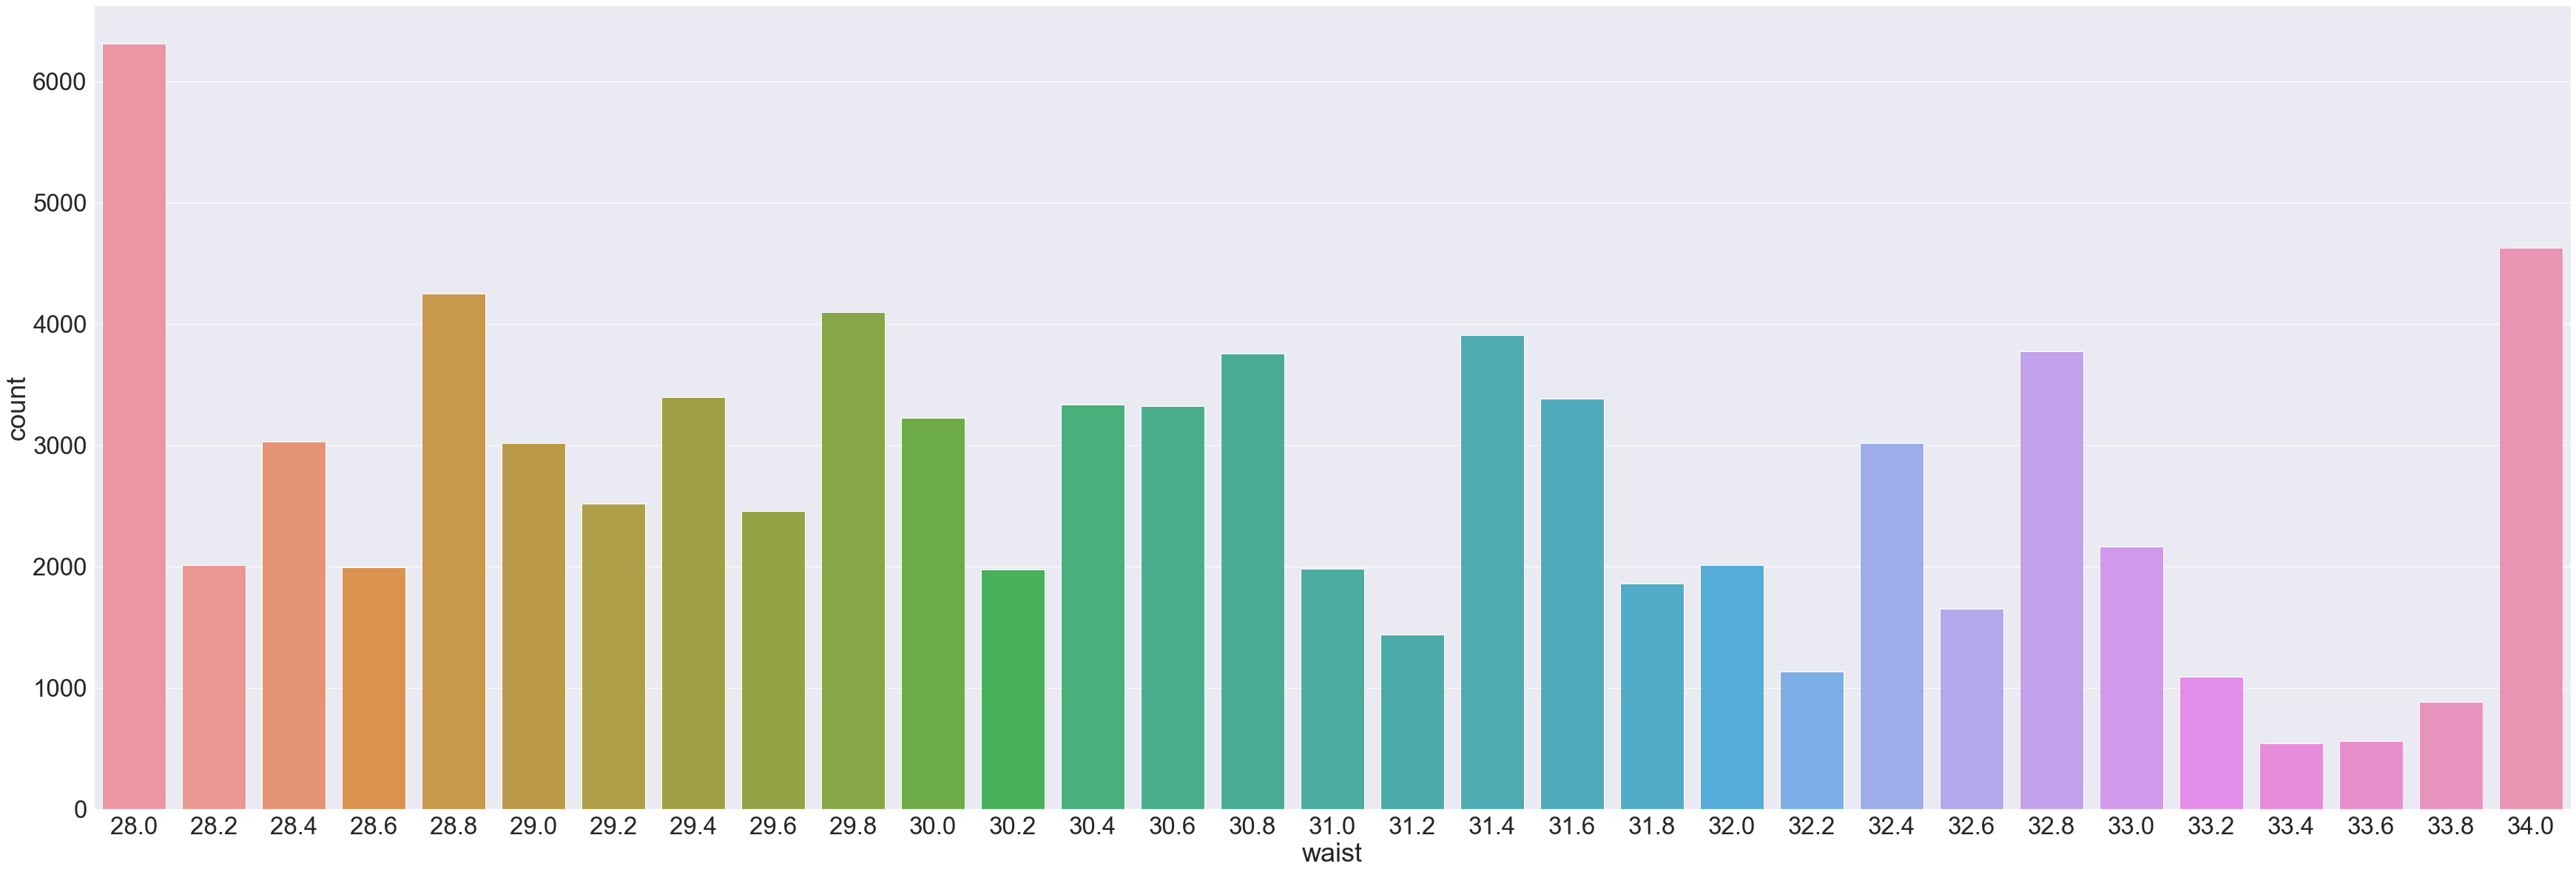

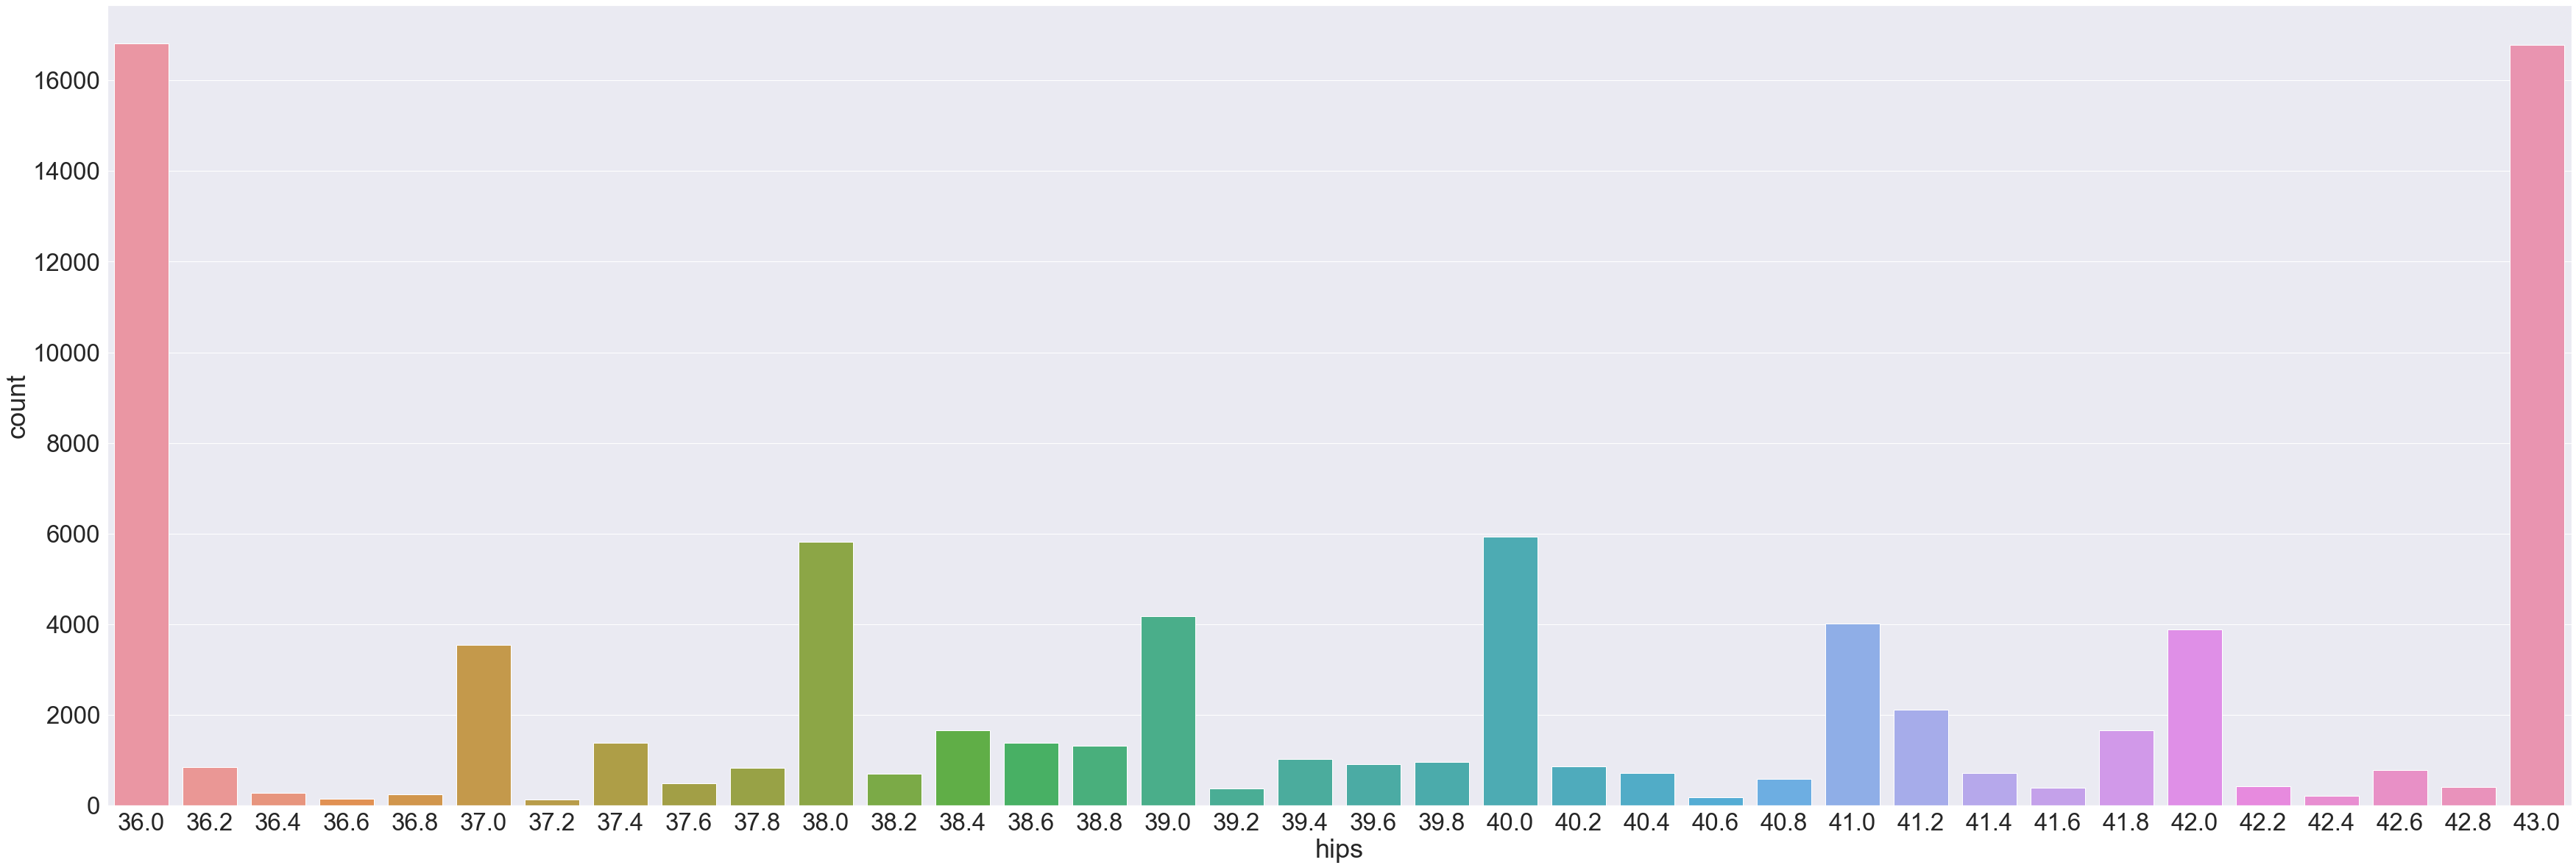

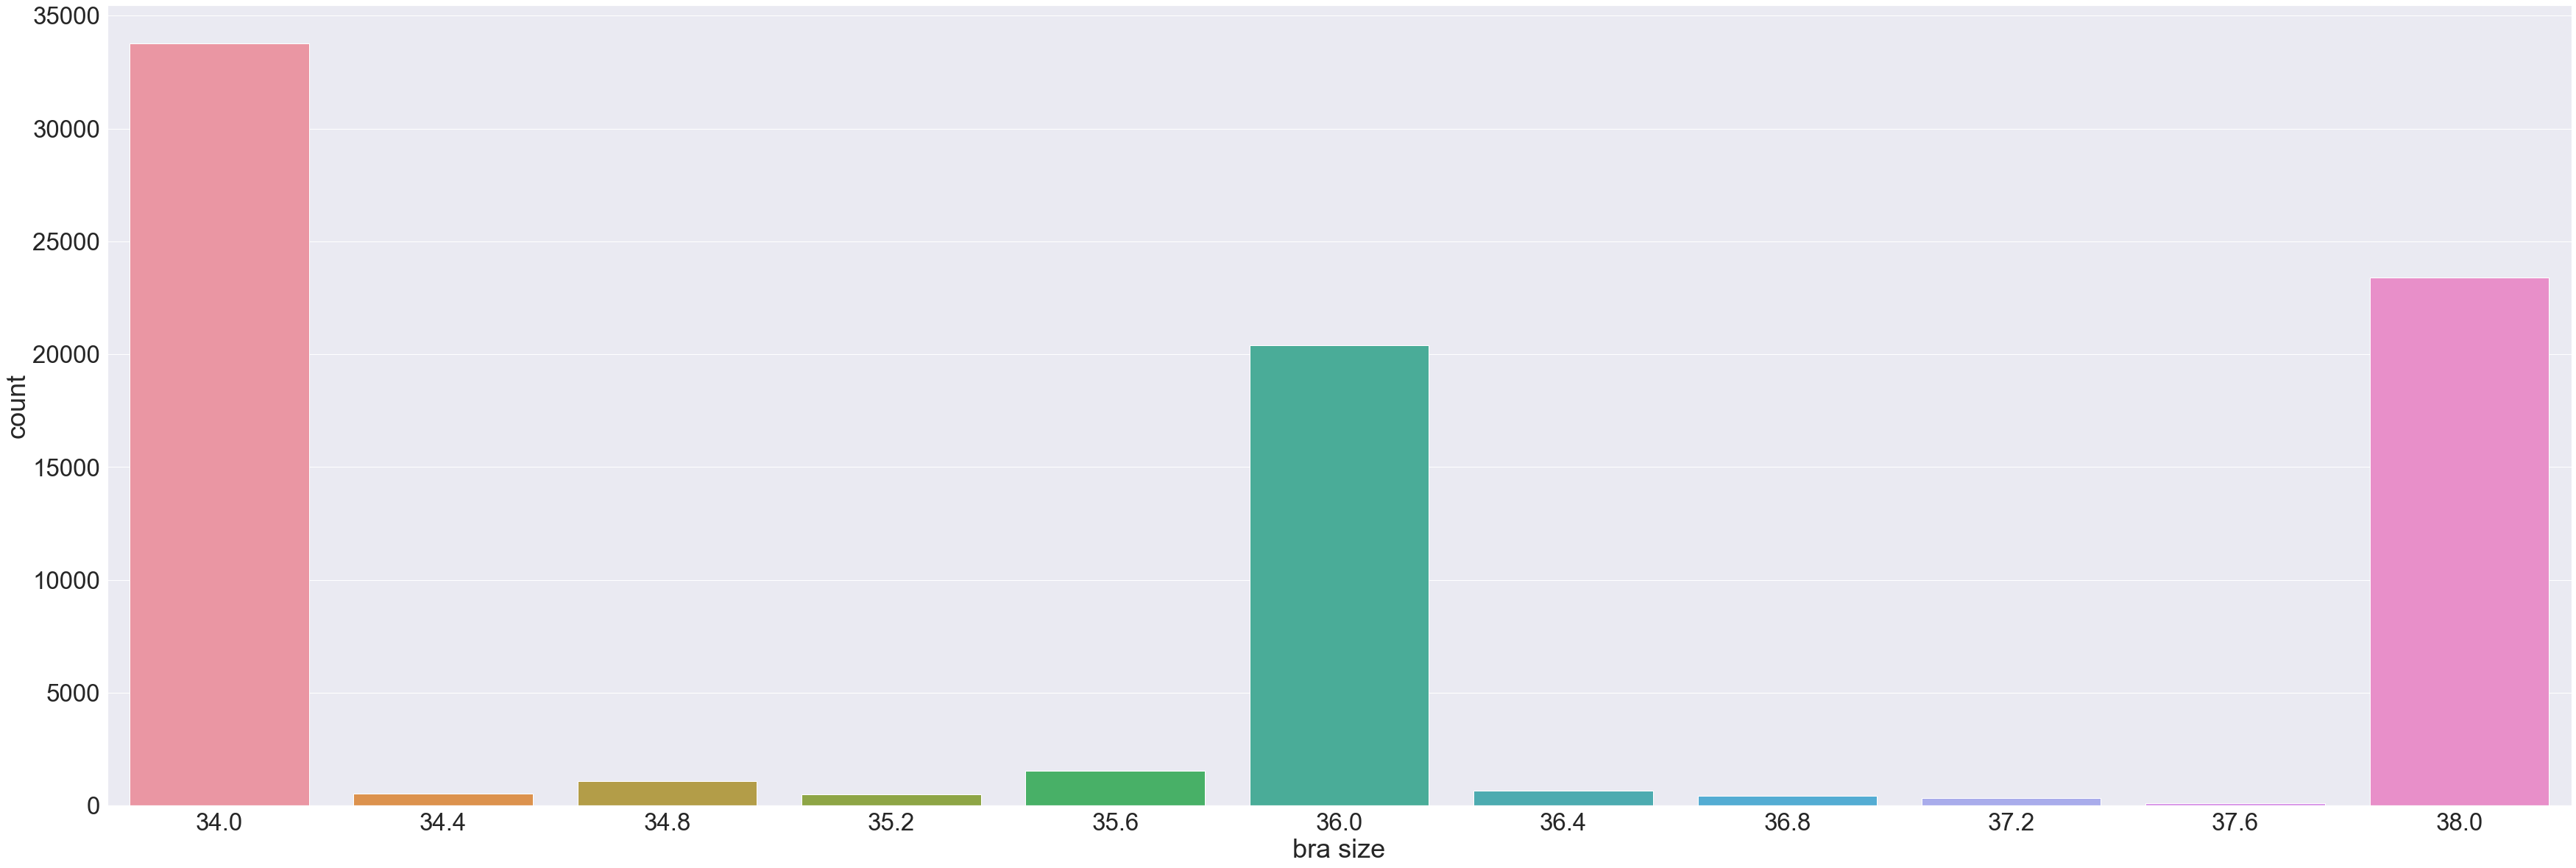

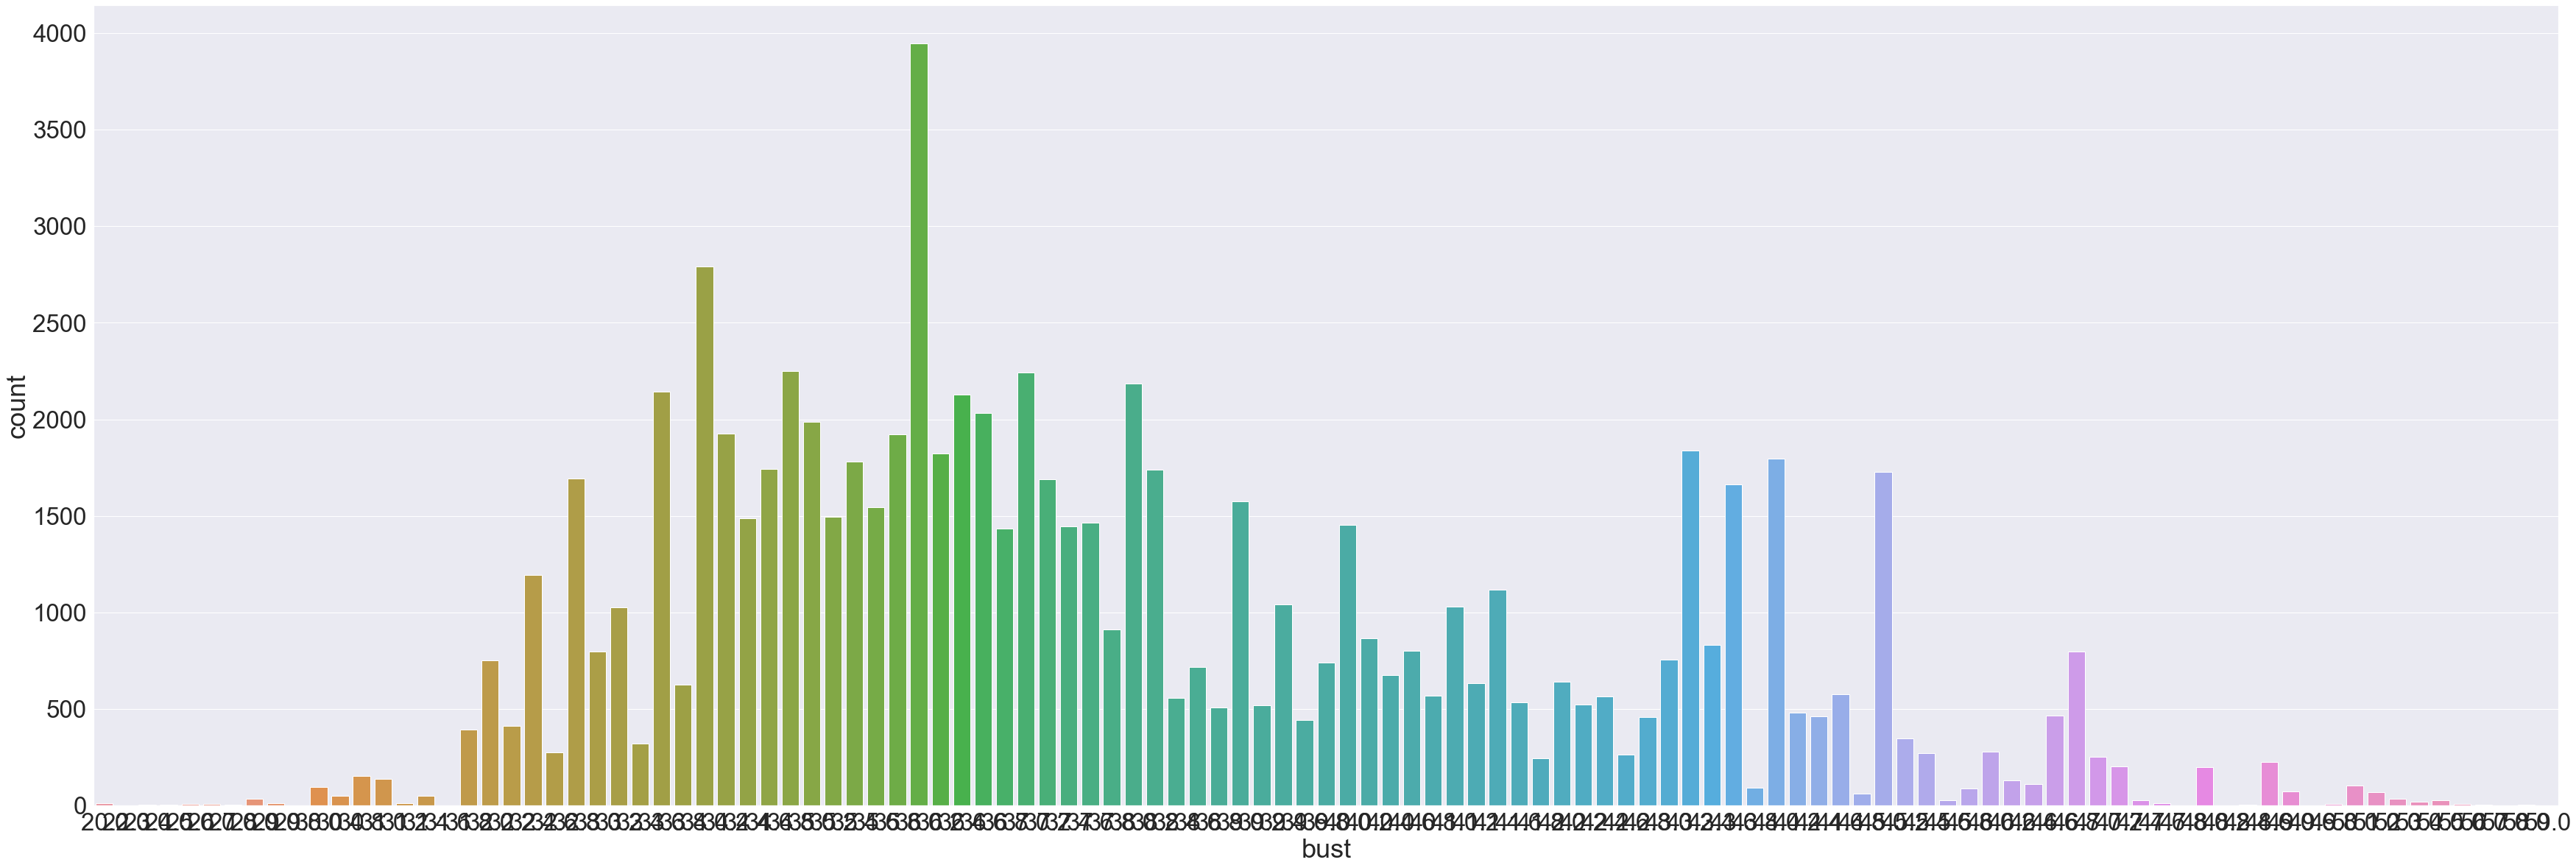

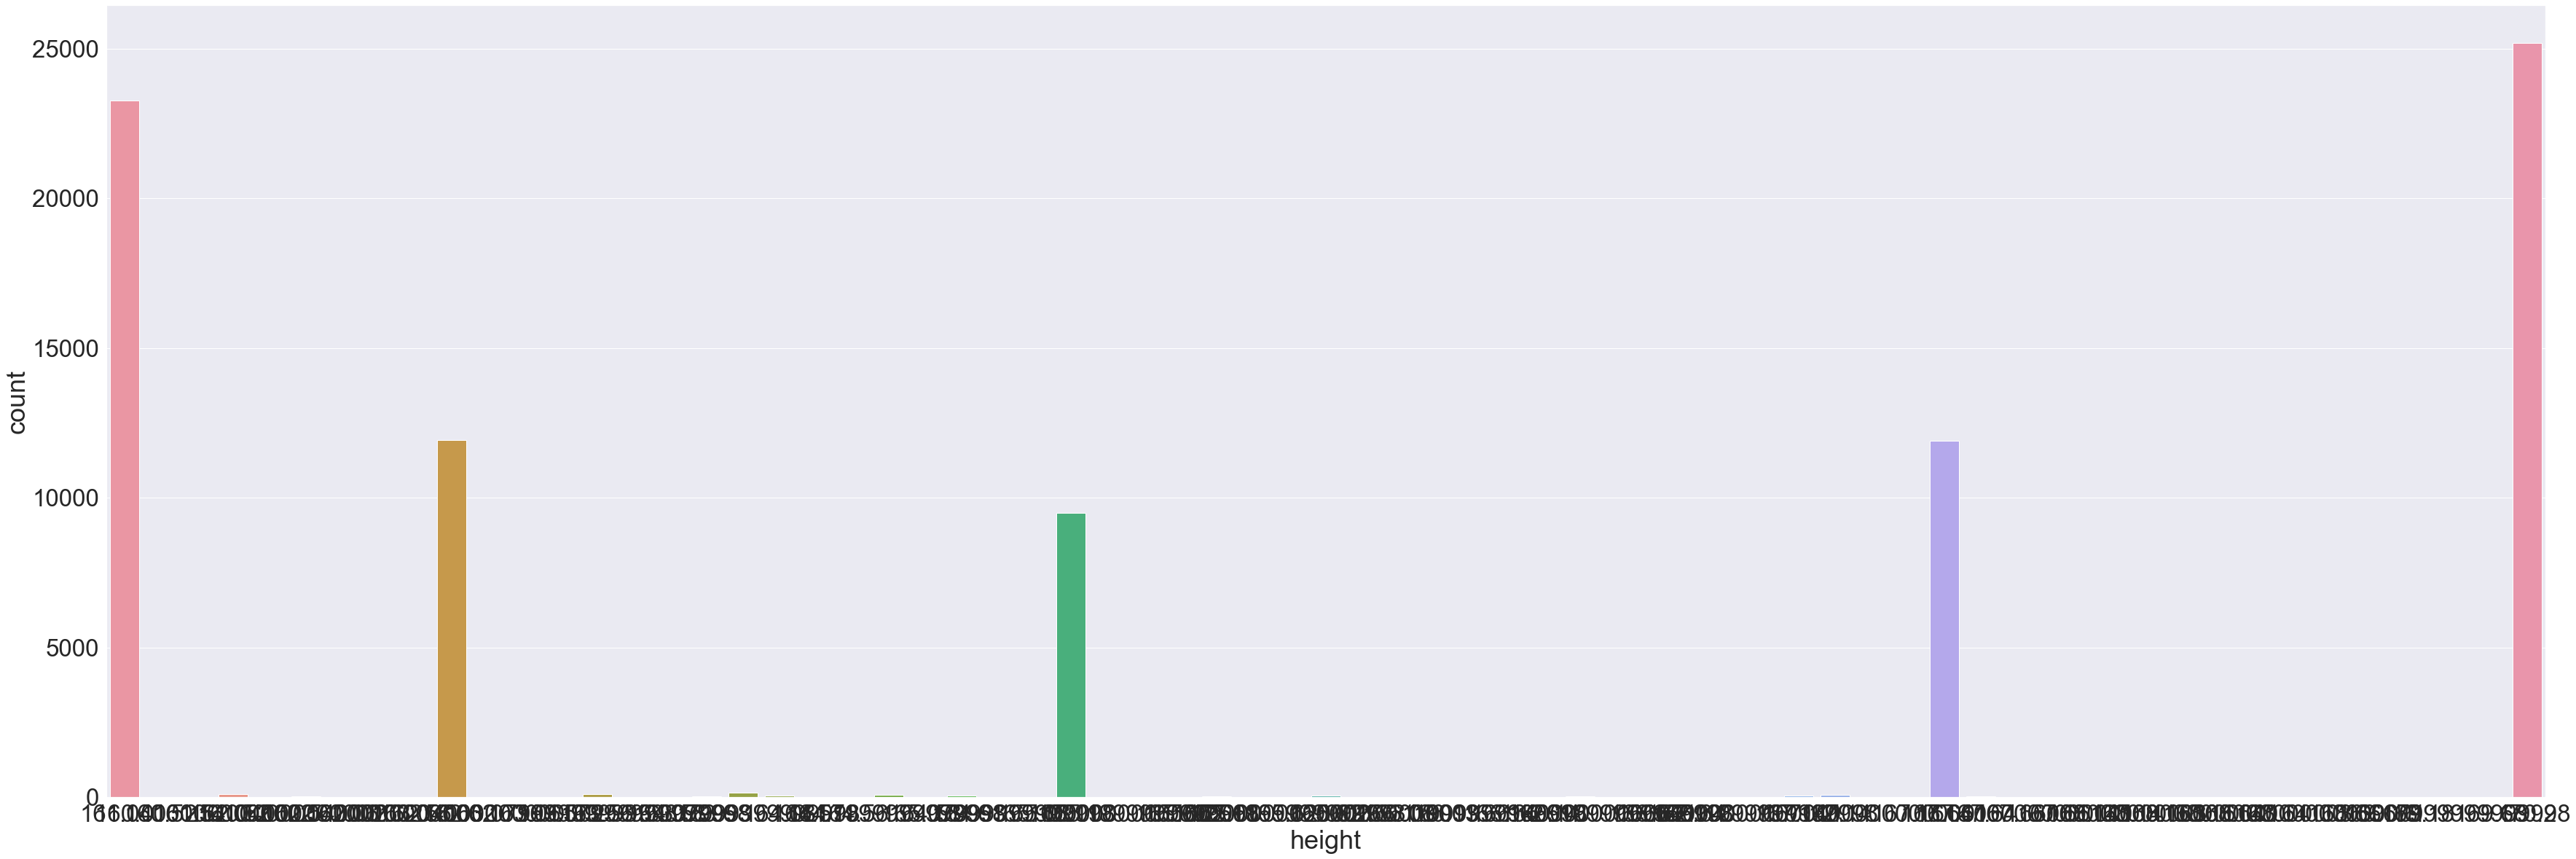

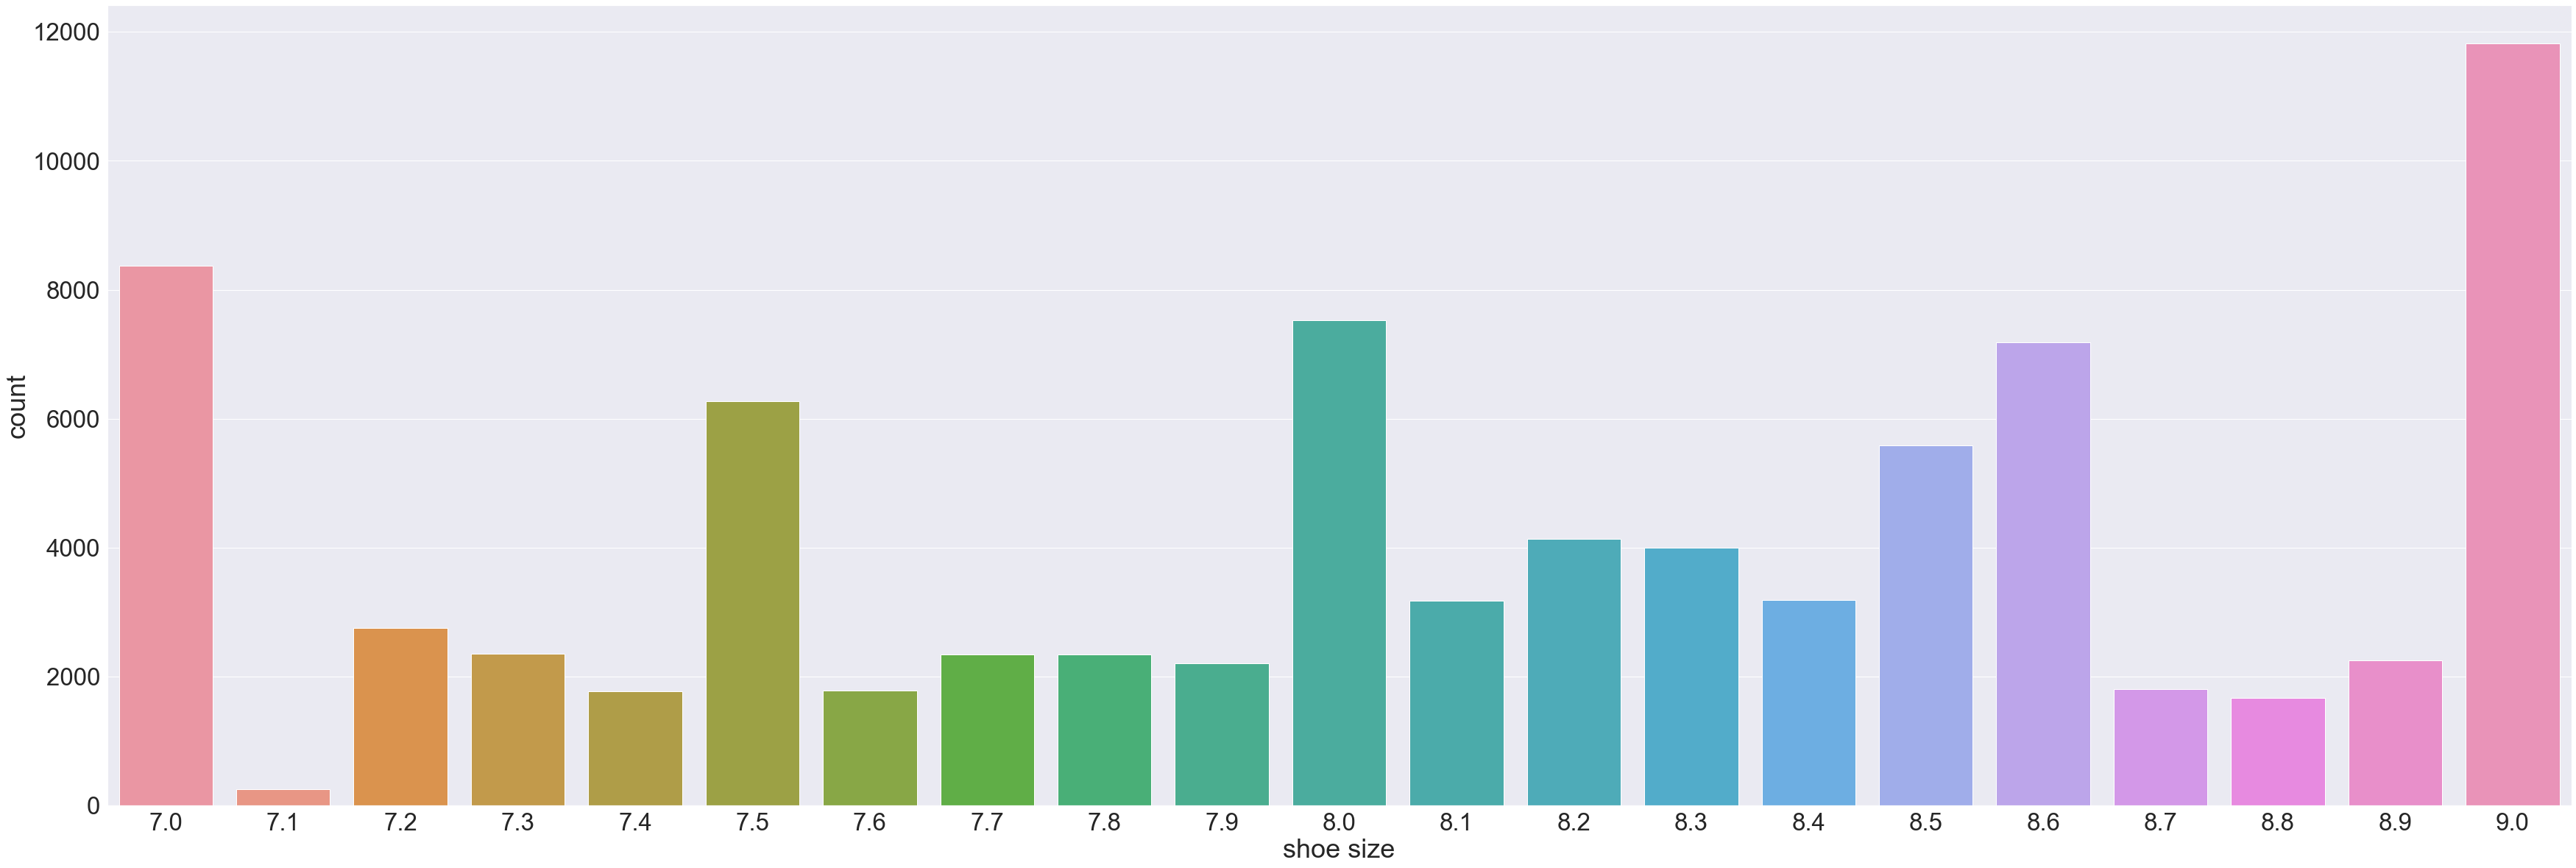

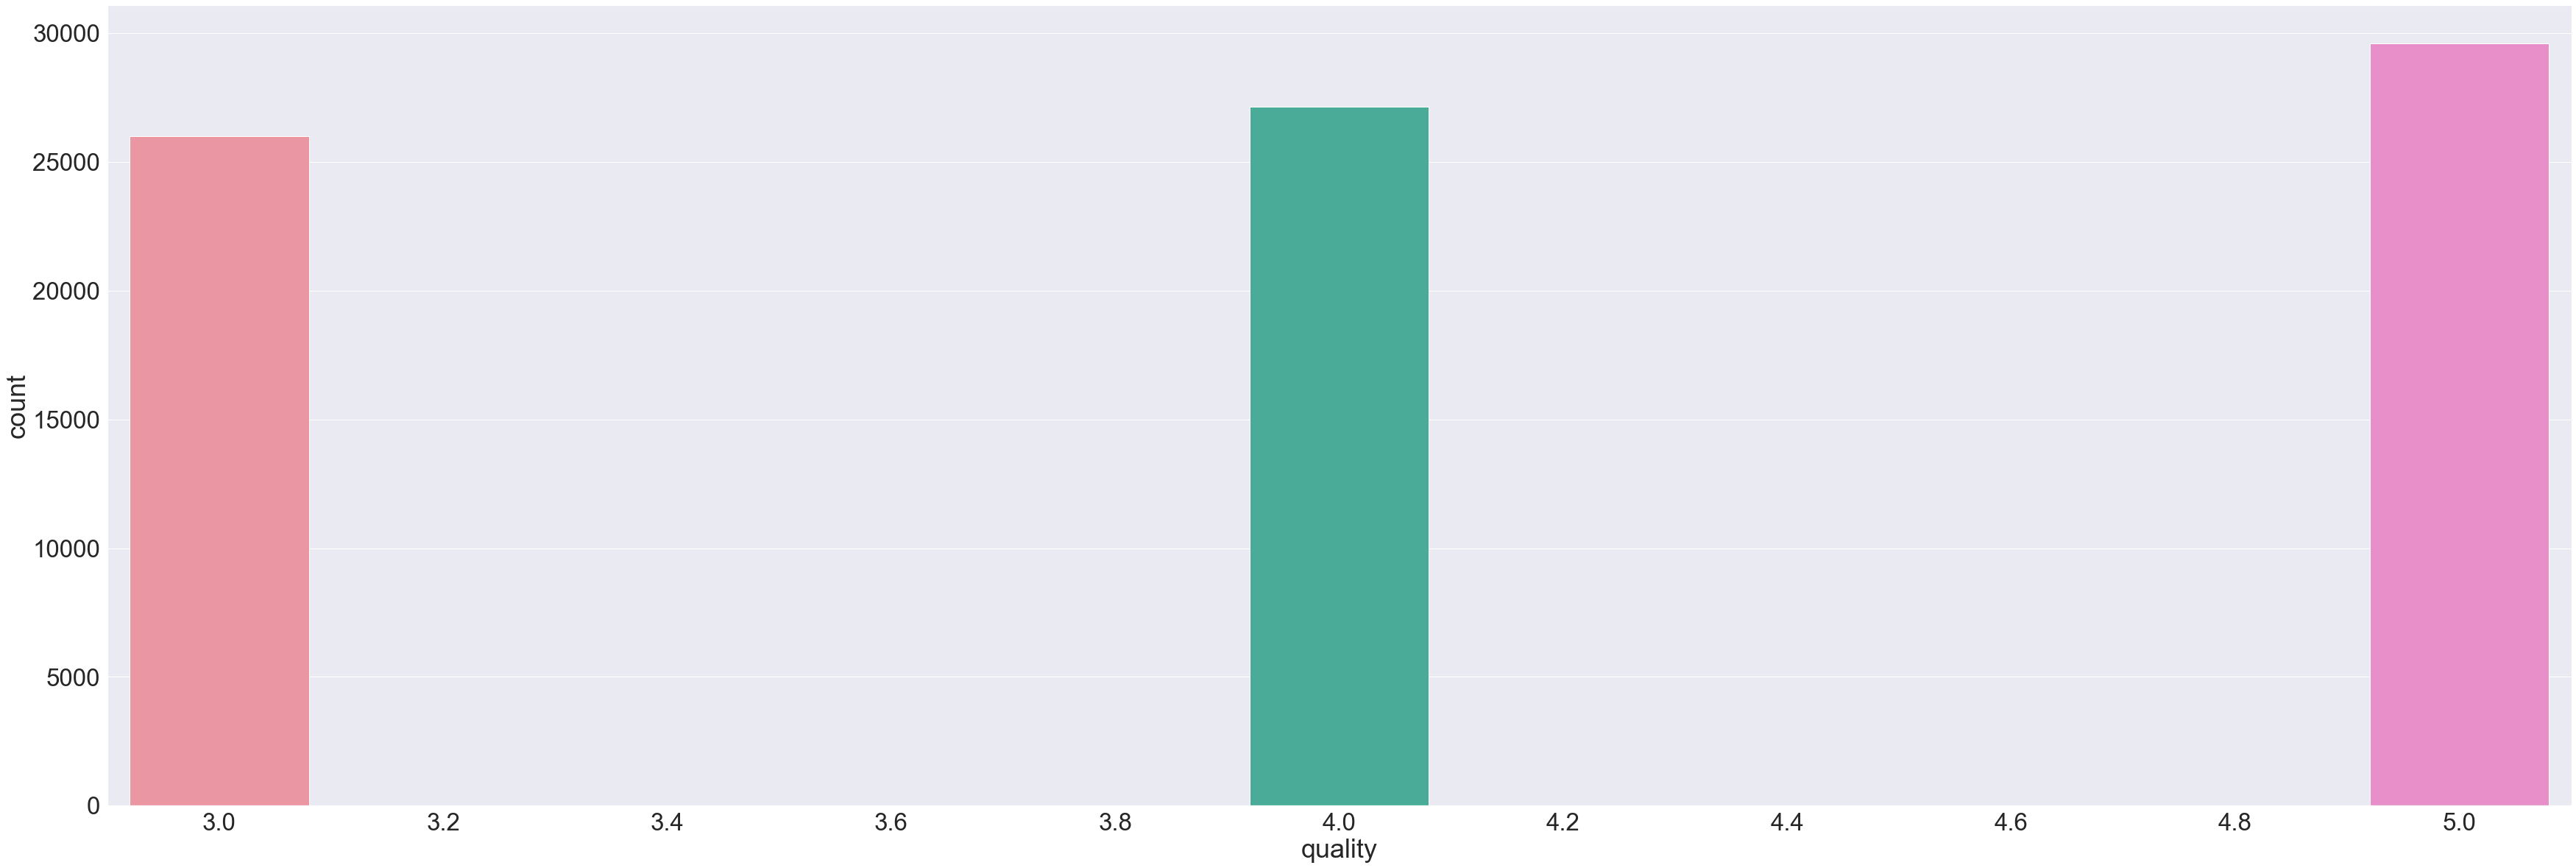

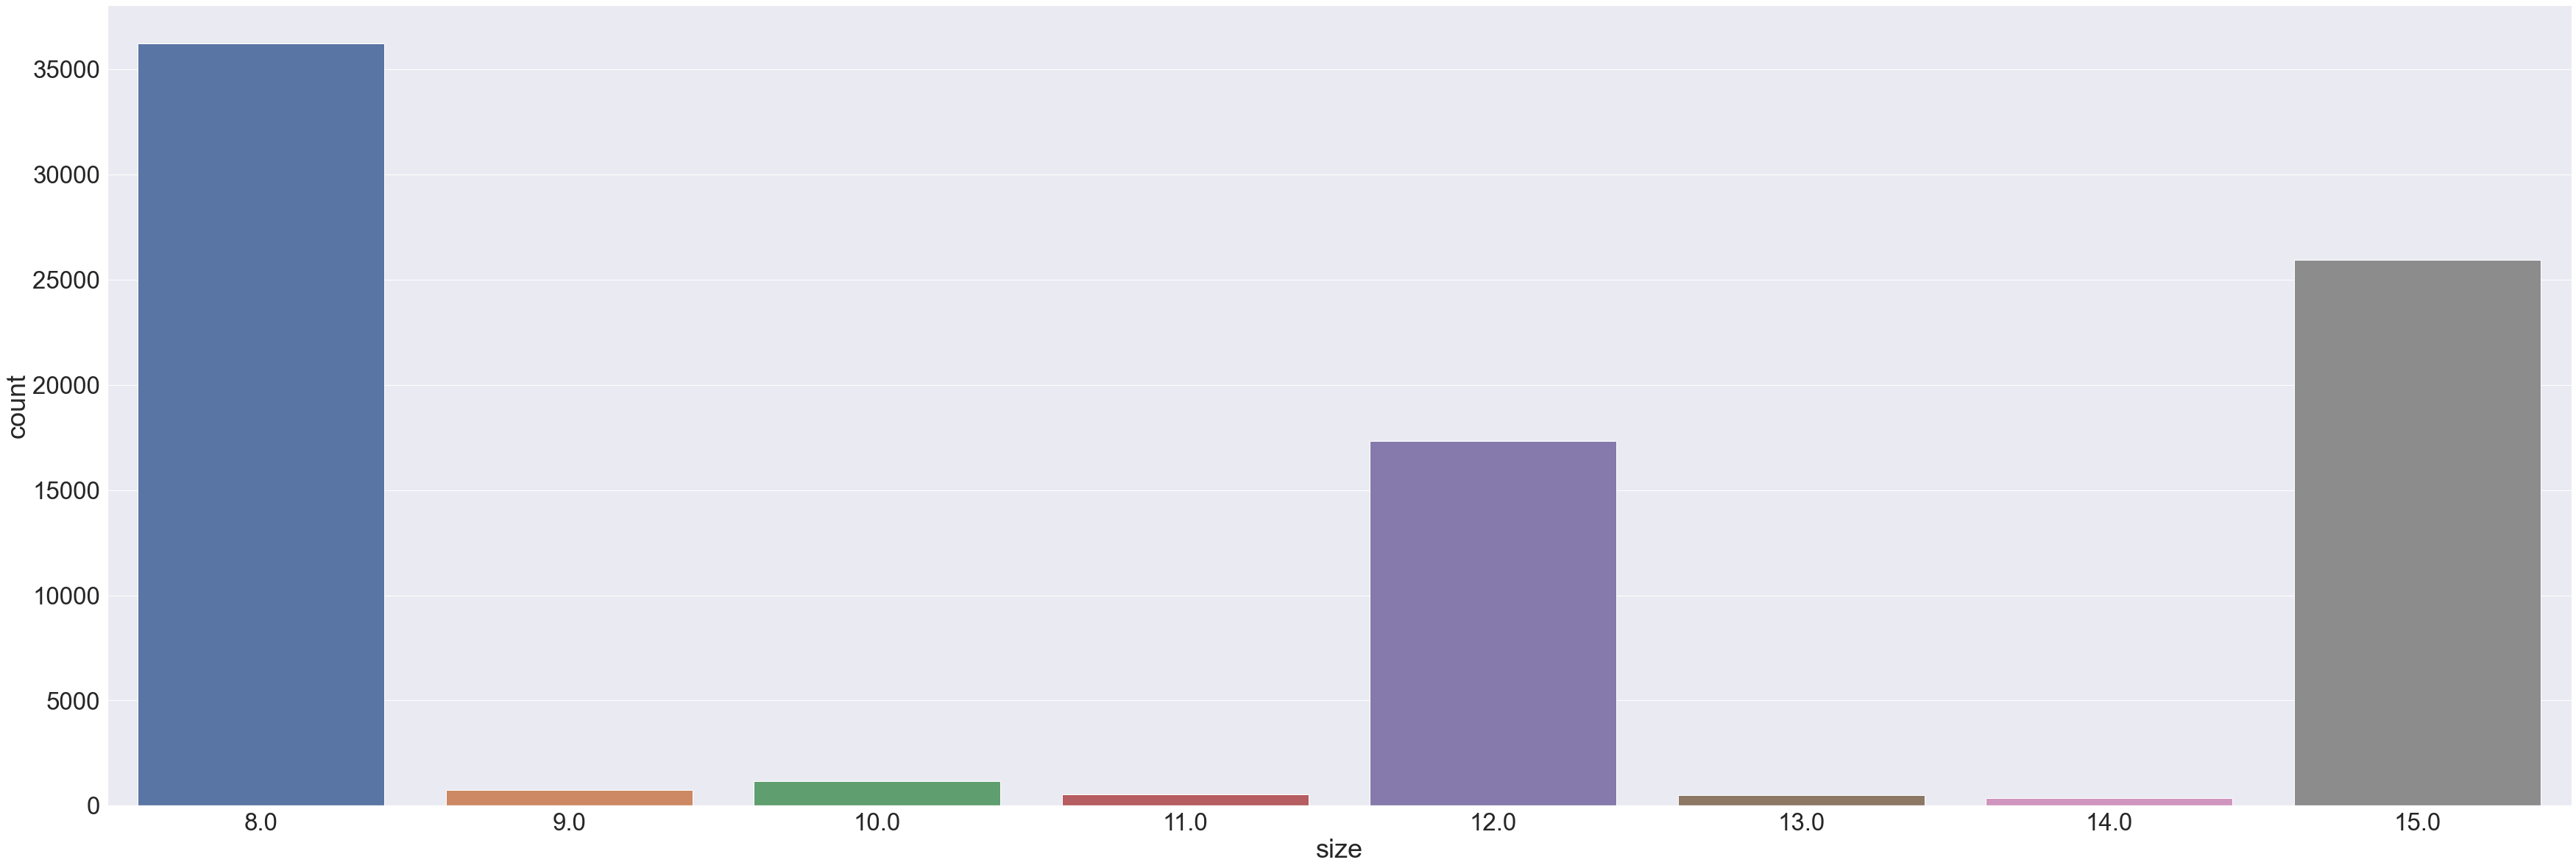

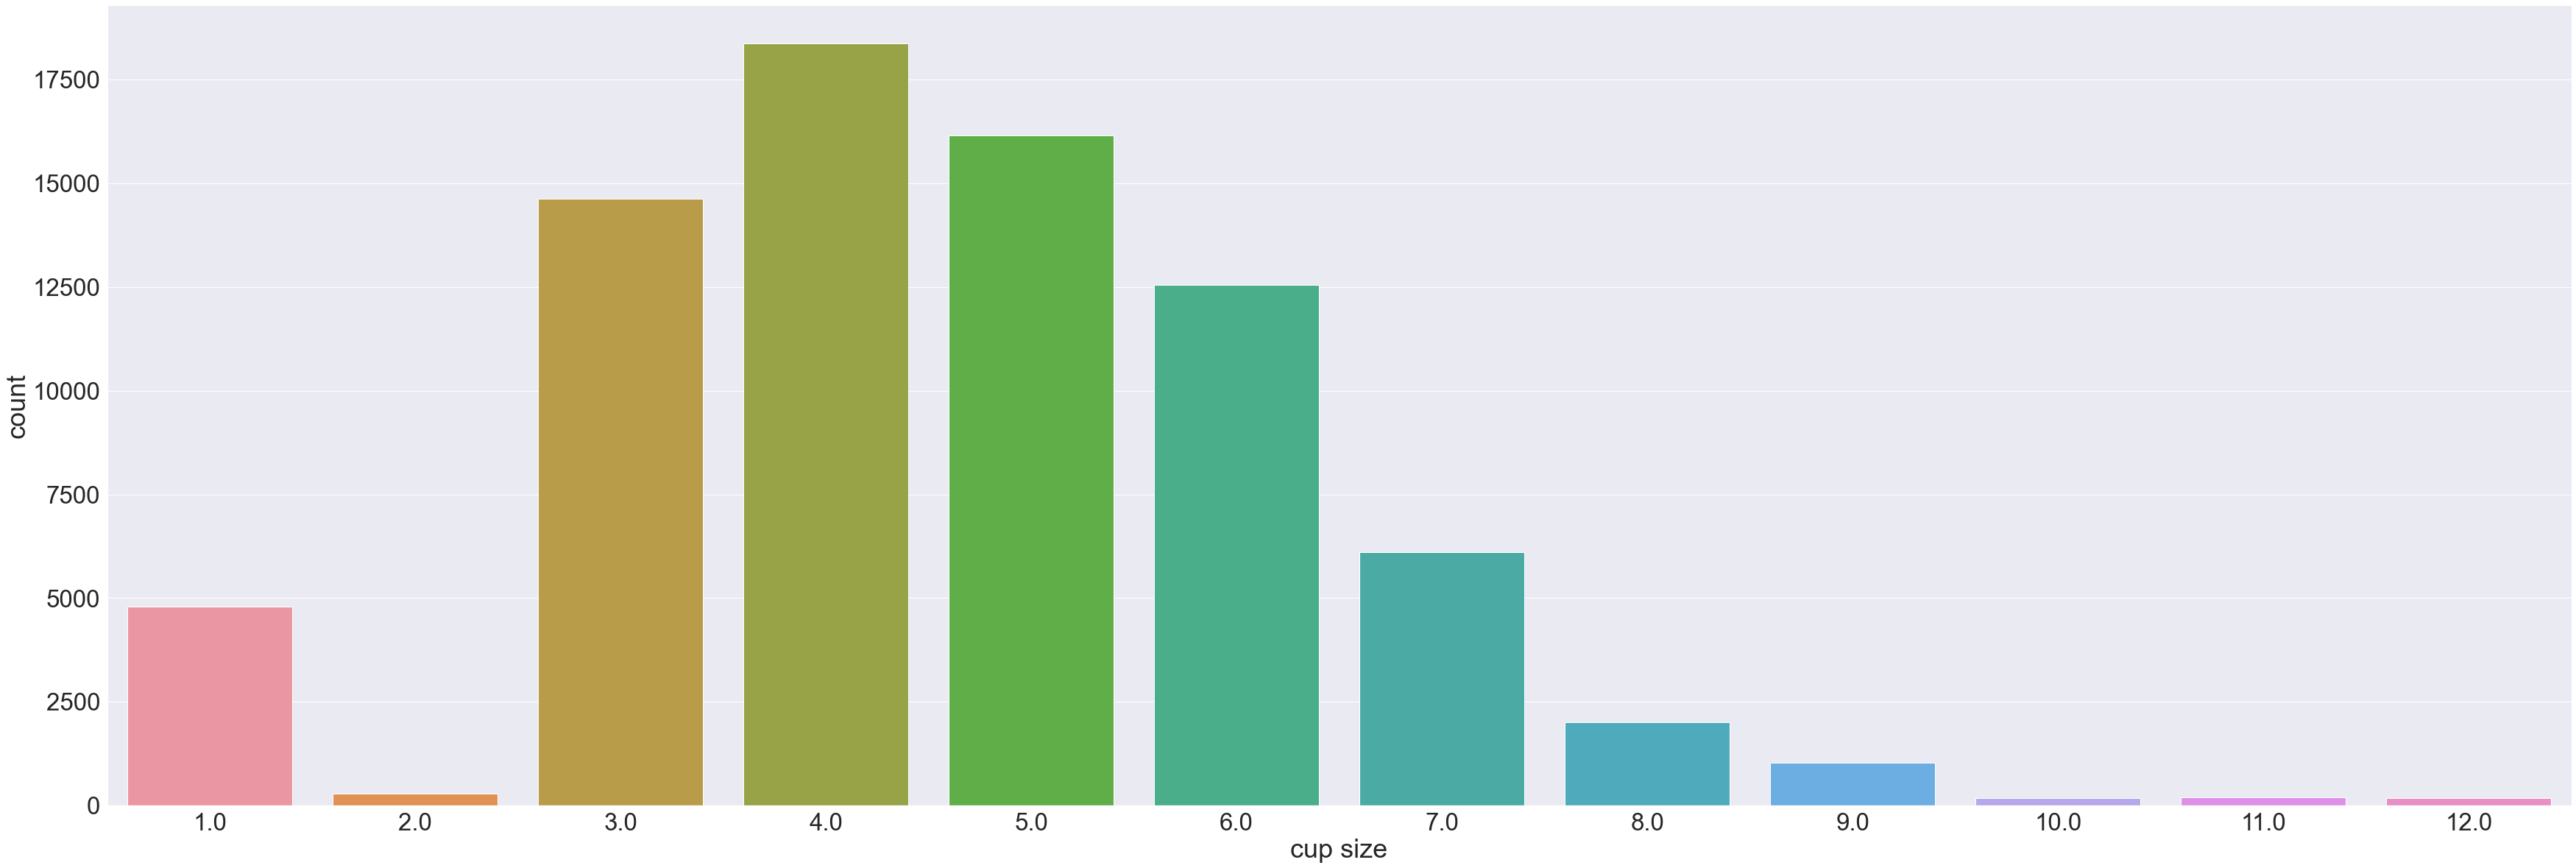

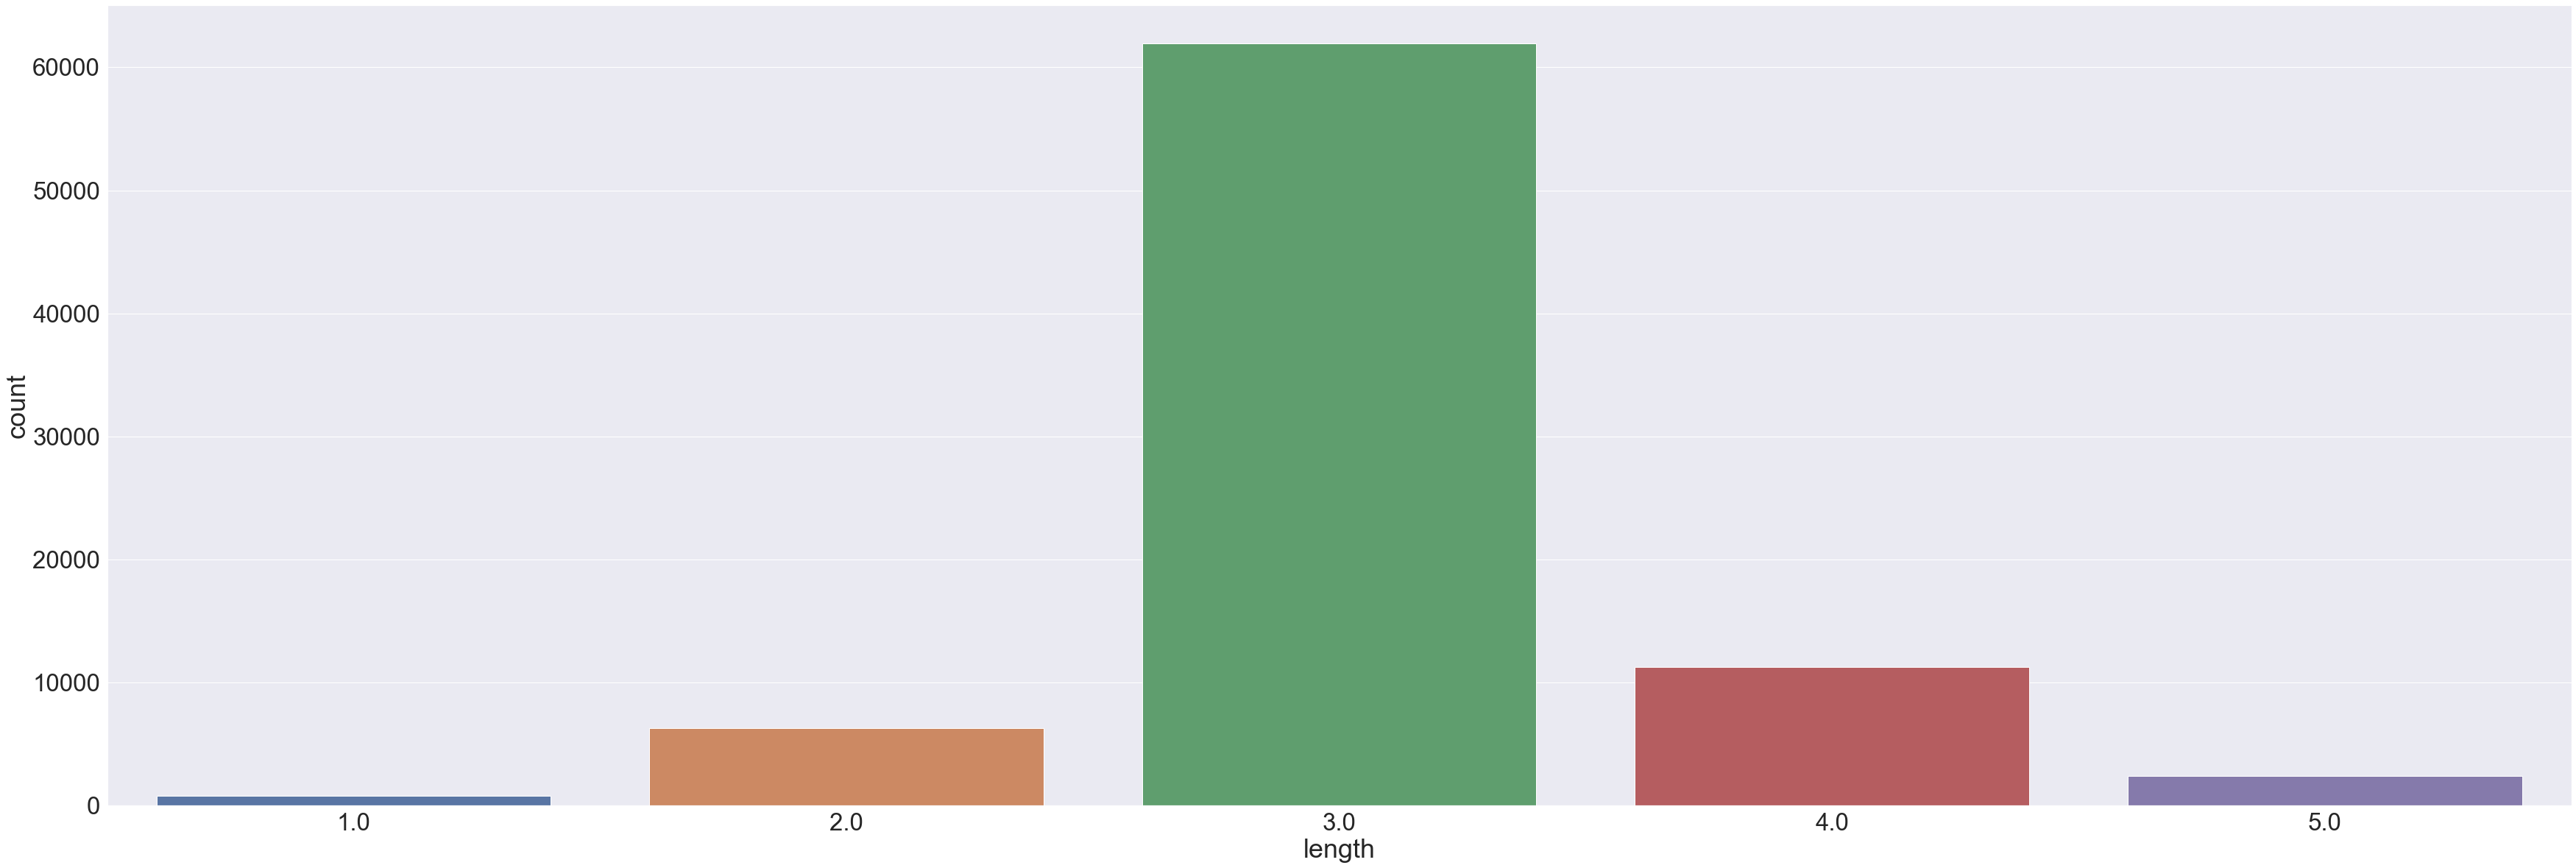

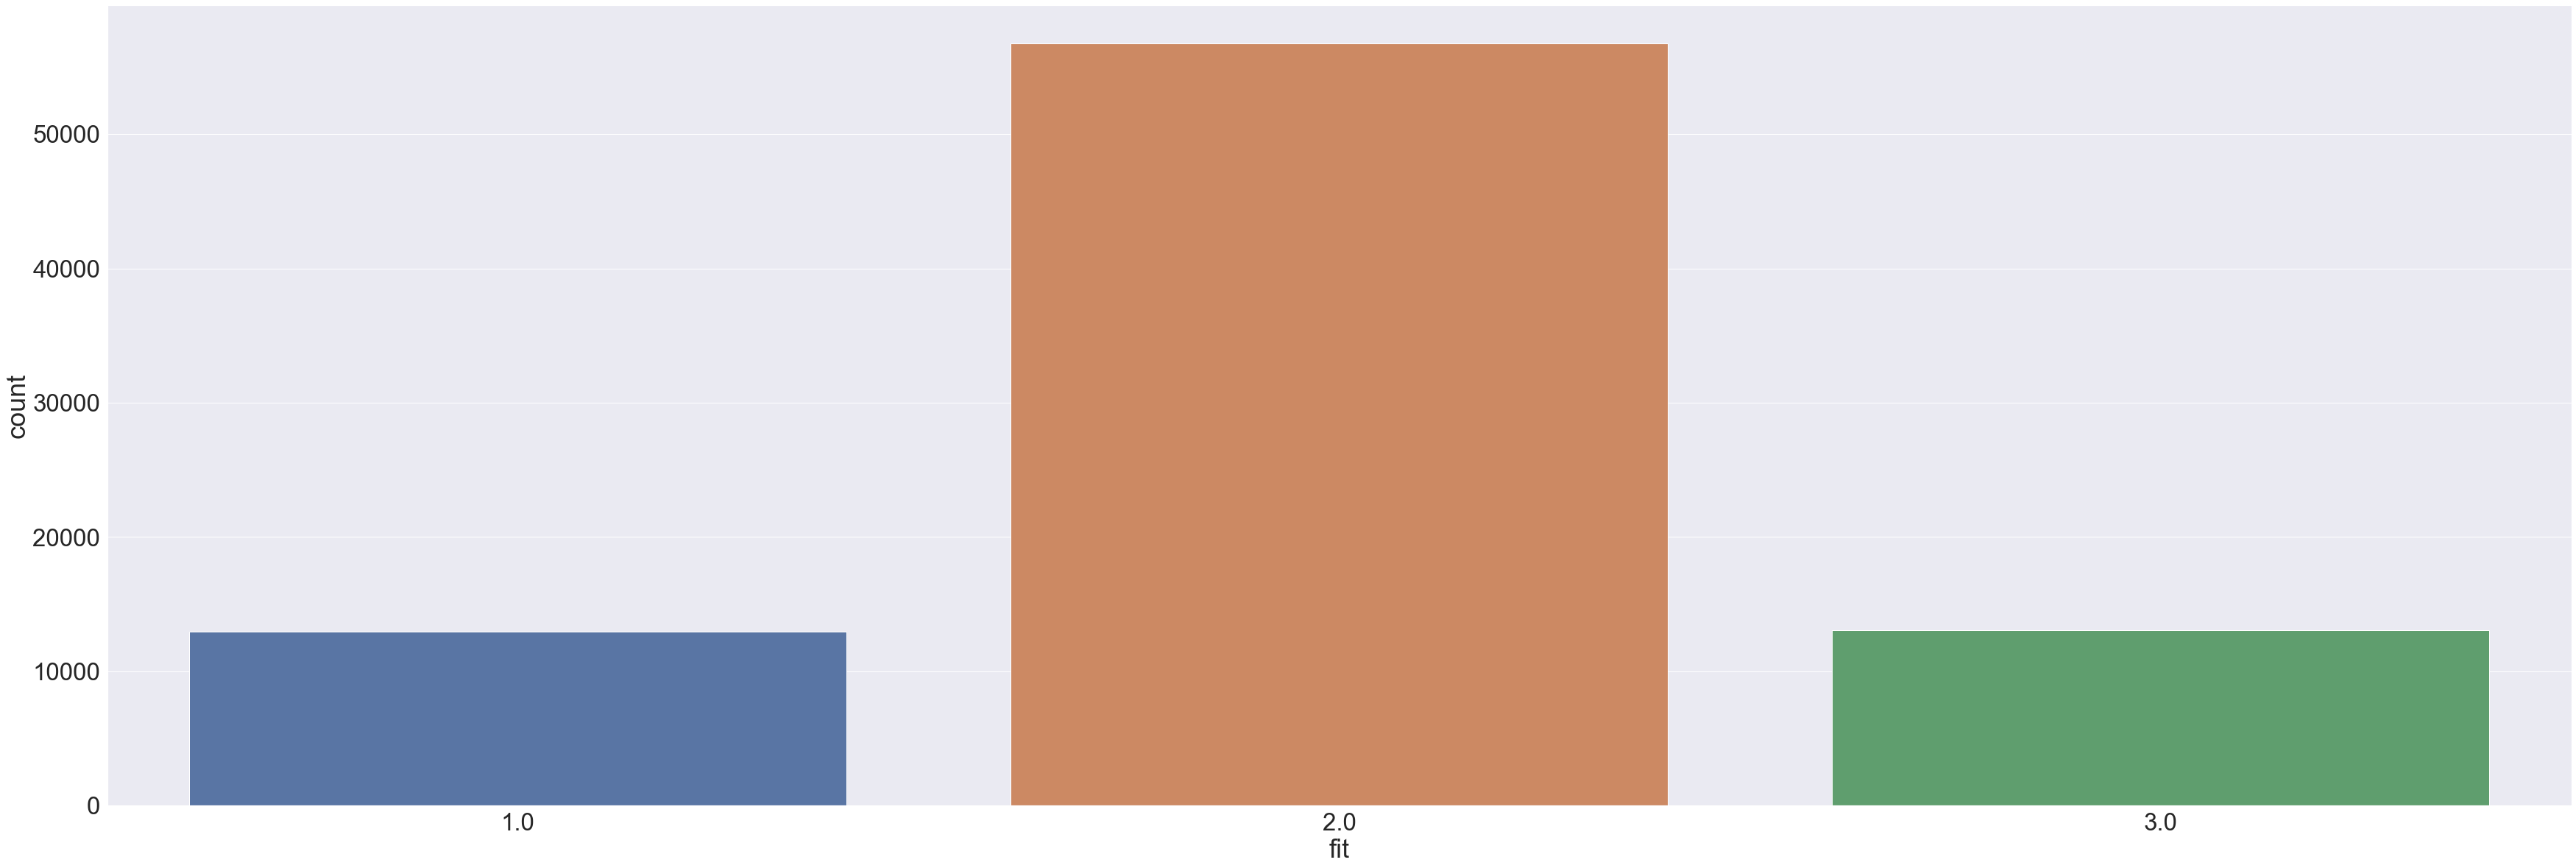

In [511]:
#Visualize distributions
for i, col in enumerate(DF):
    plt.figure(i)
    plt.figure(figsize=(60,20))
    sns.set(font_scale = 3)
    sns.countplot(x=col, data=DF)

### Build a Keras based MLP for predicting clothing size

In [512]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D 
from tensorflow.keras.optimizers import RMSprop 
from tensorflow.keras.layers import Dense, Activation
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [513]:
#drop any rows that have nan
DF.dropna(inplace=True)
DF.shape

(76516, 11)

Independent variables = cup size, length, size, waist, hips, bra size, height, shoe size

Dependent variables = Size

In [514]:
features = ['cup size', 'length', 'fit', 'waist', 'hips', 'bra size', 'height', 'shoe size' ]
X = DF[features]
Y = DF['size']

##### Model Parameters and Metrics

My model is regression, therefore I used metrics that are appropriate including: MSE, RMSE, ADAMS. Additionally, the activation in my models was relu, commonly used in regression problems. 

### Models

A series of models are built below to test which one is most accurate. For each model I will: 
 - Define, compile, fit Model
 - Predict on the Test Data and Compute Evaluation Metrics

In [533]:
#First model
model = Sequential()

In [534]:
#starting with an arbituary number of layers
model.add(Dense(144, activation='relu', input_shape=(8,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(36, activation='relu'))
model.add(Dense(1, activation='relu'))

model.summary()

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_279 (Dense)            (None, 144)               1296      
_________________________________________________________________
dense_280 (Dense)            (None, 64)                9280      
_________________________________________________________________
dense_281 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_282 (Dense)            (None, 36)                2340      
_________________________________________________________________
dense_283 (Dense)            (None, 1)                 37        
Total params: 17,113
Trainable params: 17,113
Non-trainable params: 0
_________________________________________________________________


In [535]:
#compile & fit
model.compile(loss= "mean_absolute_error" , optimizer="adam", metrics=["mean_squared_error"])

In [536]:
history = model.fit(X_train, y_train, epochs=20, batch_size=10, verbose=1, validation_split=0.2)
#call history in proper format and visualize it 

Epoch 1/20
4897/4897 [==============================] - 3s 667us/step - loss: 1.3256 - mean_squared_error: 4.3509 - val_loss: 1.1031 - val_mean_squared_error: 3.4966
Epoch 2/20
4897/4897 [==============================] - 3s 630us/step - loss: 1.1410 - mean_squared_error: 3.6453 - val_loss: 1.1453 - val_mean_squared_error: 3.6564
Epoch 3/20
4897/4897 [==============================] - 3s 619us/step - loss: 1.1183 - mean_squared_error: 3.6955 - val_loss: 1.1324 - val_mean_squared_error: 3.6674
Epoch 4/20
4897/4897 [==============================] - 3s 673us/step - loss: 1.0948 - mean_squared_error: 3.7247 - val_loss: 1.0841 - val_mean_squared_error: 3.6234
Epoch 5/20
4897/4897 [==============================] - 3s 633us/step - loss: 1.0746 - mean_squared_error: 3.7289 - val_loss: 1.0340 - val_mean_squared_error: 3.6541
Epoch 6/20
4897/4897 [==============================] - 3s 659us/step - loss: 1.0670 - mean_squared_error: 3.7549 - val_loss: 1.0609 - val_mean_squared_error: 3.7361
Epoc

In [537]:
#Predict on the Test Data and Compute Evaluation Metrics
pred_train= model.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train)))

pred= model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred))) 

1.9290492402006625
1.9316247604241386


dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


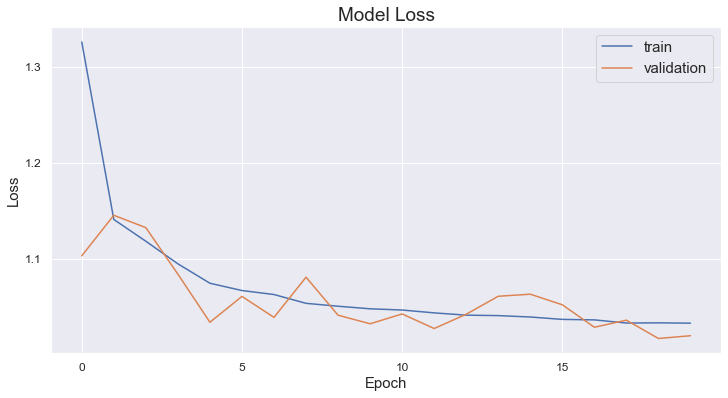

In [538]:
print(history.history.keys())
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontsize=19)
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(['train', 'validation'], fontsize=15, loc='best')
plt.show()

In [569]:
#Second Model - In the second model I will use less layers to see how it compares
model1 = Sequential()

In [570]:
model1.add(Dense(64, activation='relu', input_shape=(8,)))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(1, activation='relu'))

model1.summary()

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_300 (Dense)            (None, 64)                576       
_________________________________________________________________
dense_301 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_302 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_303 (Dense)            (None, 1)                 65        
Total params: 8,961
Trainable params: 8,961
Non-trainable params: 0
_________________________________________________________________


In [571]:
#compile & fit
model1.compile(loss= "mean_absolute_error" , optimizer="adam", metrics=["mean_squared_error"])

In [572]:
history = model1.fit(X_train, y_train, epochs=20, batch_size=10, verbose=1, validation_split=0.2)
history

Epoch 1/20
4897/4897 [==============================] - 3s 592us/step - loss: 1.3355 - mean_squared_error: 4.5237 - val_loss: 1.1655 - val_mean_squared_error: 3.7004
Epoch 2/20
4897/4897 [==============================] - 3s 549us/step - loss: 1.1330 - mean_squared_error: 3.6343 - val_loss: 1.1026 - val_mean_squared_error: 3.6356
Epoch 3/20
4897/4897 [==============================] - 3s 604us/step - loss: 1.1101 - mean_squared_error: 3.6883 - val_loss: 1.0552 - val_mean_squared_error: 3.6326
Epoch 4/20
4897/4897 [==============================] - 3s 572us/step - loss: 1.0928 - mean_squared_error: 3.6940 - val_loss: 1.0662 - val_mean_squared_error: 3.6198
Epoch 5/20
4897/4897 [==============================] - 3s 585us/step - loss: 1.0835 - mean_squared_error: 3.6973 - val_loss: 1.0624 - val_mean_squared_error: 3.5753
Epoch 6/20
4897/4897 [==============================] - 3s 559us/step - loss: 1.0767 - mean_squared_error: 3.7230 - val_loss: 1.0950 - val_mean_squared_error: 3.6066
Epoc

In [573]:
#Predict on the Test Data and Compute Evaluation Metrics
pred_train1= model1.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train)))

pred1 = model1.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred))) 

1.9282704939324165
1.9422921375701154


dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


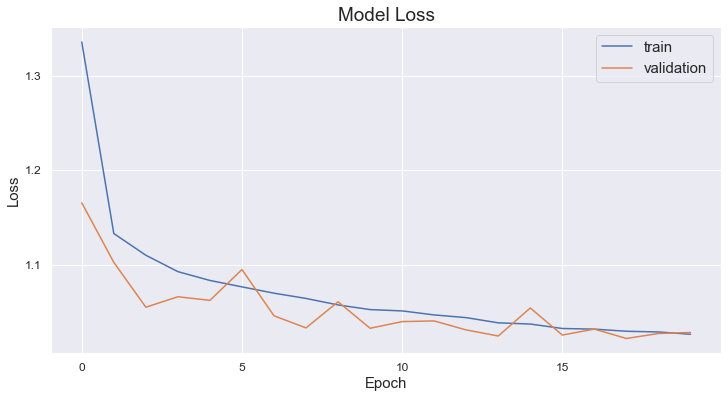

In [574]:
print(history.history.keys())
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontsize=19)
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(['train', 'validation'], fontsize=15, loc='best')
plt.show()

In [545]:
#Third model - With the same model as above, I will add a dropout layer to compare and see whether or not it's overfitted

In [598]:
model2 = Sequential()

In [599]:
model2.add(Dense(64, activation='relu', input_shape=(8,)))
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.1))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(1, activation='relu'))

model2.summary()

Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_329 (Dense)            (None, 64)                576       
_________________________________________________________________
dense_330 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_27 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_331 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_332 (Dense)            (None, 1)                 65        
Total params: 8,961
Trainable params: 8,961
Non-trainable params: 0
_________________________________________________________________


In [600]:
#compile & fit
model2.compile(loss= "mean_absolute_error" , optimizer="adam", metrics=["mean_squared_error"])
history = model2.fit(X_train, y_train, epochs=20, batch_size=10, verbose=1, validation_split=0.2)
history

Epoch 1/20
4897/4897 [==============================] - 3s 582us/step - loss: 1.4703 - mean_squared_error: 4.8496 - val_loss: 1.1519 - val_mean_squared_error: 3.5264
Epoch 2/20
4897/4897 [==============================] - 3s 567us/step - loss: 1.2038 - mean_squared_error: 3.6816 - val_loss: 1.0897 - val_mean_squared_error: 3.4679
Epoch 3/20
4897/4897 [==============================] - 3s 564us/step - loss: 1.1415 - mean_squared_error: 3.7260 - val_loss: 1.0776 - val_mean_squared_error: 3.5994
Epoch 4/20
4897/4897 [==============================] - 3s 564us/step - loss: 1.1259 - mean_squared_error: 3.7494 - val_loss: 1.0962 - val_mean_squared_error: 3.6391
Epoch 5/20
4897/4897 [==============================] - 3s 563us/step - loss: 1.1136 - mean_squared_error: 3.7483 - val_loss: 1.1480 - val_mean_squared_error: 3.6133
Epoch 6/20
4897/4897 [==============================] - 3s 563us/step - loss: 1.1049 - mean_squared_error: 3.7252 - val_loss: 1.1170 - val_mean_squared_error: 3.6225
Epoc

In [601]:
#Predict on the Test Data and Compute Evaluation Metrics
pred_train2 = model2.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train)))

pred2 = model2.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred))) 

1.9282704939324165
1.9422921375701154


dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


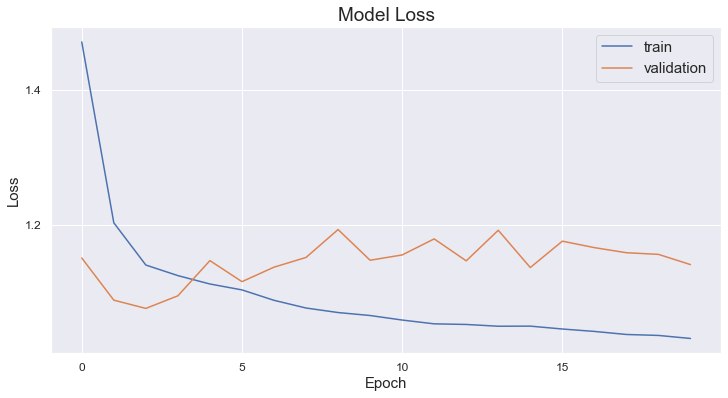

In [602]:
print(history.history.keys())
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontsize=19)
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(['train', 'validation'], fontsize=15, loc='best')
plt.show()

It looks like adding a dropout layer decreased the model's accuracy. 

In [603]:
#Fourth Model - I will add more layers than the original model to compare
model3 = Sequential()

In [604]:
model3.add(Dense(144, activation='relu', input_shape=(8,)))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(36, activation='relu'))
model3.add(Dense(36, activation='relu'))
model3.add(Dense(36, activation='relu'))
model3.add(Dense(1, activation='relu'))

model3.summary()

Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_333 (Dense)            (None, 144)               1296      
_________________________________________________________________
dense_334 (Dense)            (None, 64)                9280      
_________________________________________________________________
dense_335 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_336 (Dense)            (None, 36)                2340      
_________________________________________________________________
dense_337 (Dense)            (None, 36)                1332      
_________________________________________________________________
dense_338 (Dense)            (None, 36)                1332      
_________________________________________________________________
dense_339 (Dense)            (None, 1)               

In [595]:
#compile & fit
model3.compile(loss= "mean_absolute_error" , optimizer="adam", metrics=["mean_squared_error"])

In [596]:
model3.fit(X_train, y_train, epochs=20, batch_size=10, verbose=1, validation_split=0.2)

Epoch 1/20
4897/4897 [==============================] - 3s 678us/step - loss: 1.3437 - mean_squared_error: 4.5822 - val_loss: 1.1610 - val_mean_squared_error: 3.4176
Epoch 2/20
4897/4897 [==============================] - 3s 686us/step - loss: 1.1381 - mean_squared_error: 3.6589 - val_loss: 1.1319 - val_mean_squared_error: 3.5882
Epoch 3/20
4897/4897 [==============================] - 3s 703us/step - loss: 1.1058 - mean_squared_error: 3.7110 - val_loss: 1.2086 - val_mean_squared_error: 3.7692
Epoch 4/20
4897/4897 [==============================] - 3s 695us/step - loss: 1.0919 - mean_squared_error: 3.7304 - val_loss: 1.0575 - val_mean_squared_error: 3.6942
Epoch 5/20
4897/4897 [==============================] - 3s 679us/step - loss: 1.0813 - mean_squared_error: 3.7421 - val_loss: 1.0355 - val_mean_squared_error: 3.6493
Epoch 6/20
4897/4897 [==============================] - 3s 695us/step - loss: 1.0716 - mean_squared_error: 3.7443 - val_loss: 1.0571 - val_mean_squared_error: 3.7688
Epoc

In [444]:
#Predict on the Test Data and Compute Evaluation Metrics
pred_train3 = model3.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train)))

pred3 = model3.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred))) 

1.889545917903069
1.8993289737075612


dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


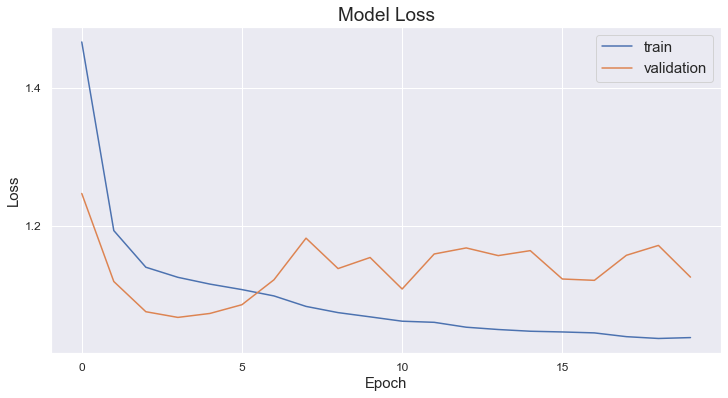

In [579]:
print(history.history.keys())
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontsize=19)
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(['train', 'validation'], fontsize=15, loc='best')
plt.show()

In [605]:
#Fifth model - Taking the 4th model, adding a dropout layer to compare
model4 = Sequential()

In [606]:
model4.add(Dense(144, activation='relu', input_shape=(8,)))
model4.add(Dense(64, activation='relu'))
model4.add(Dense(64, activation='relu'))
model4.add(Dropout(0.1))
model4.add(Dense(36, activation='relu'))
model4.add(Dense(36, activation='relu'))
model4.add(Dense(36, activation='relu'))
model4.add(Dense(1, activation='relu'))

model4.summary()

Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_340 (Dense)            (None, 144)               1296      
_________________________________________________________________
dense_341 (Dense)            (None, 64)                9280      
_________________________________________________________________
dense_342 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_28 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_343 (Dense)            (None, 36)                2340      
_________________________________________________________________
dense_344 (Dense)            (None, 36)                1332      
_________________________________________________________________
dense_345 (Dense)            (None, 36)              

In [607]:
#compile & fit
model4.compile(loss= "mean_absolute_error" , optimizer="adam", metrics=["mean_squared_error"])

In [608]:
history = model4.fit(X_train, y_train, epochs=20, batch_size=10, verbose=1, validation_split=0.2)

Epoch 1/20
4897/4897 [==============================] - 3s 694us/step - loss: 1.3660 - mean_squared_error: 4.5183 - val_loss: 1.2253 - val_mean_squared_error: 3.4231
Epoch 2/20
4897/4897 [==============================] - 3s 674us/step - loss: 1.1480 - mean_squared_error: 3.7062 - val_loss: 1.3354 - val_mean_squared_error: 3.7947
Epoch 3/20
4897/4897 [==============================] - 3s 673us/step - loss: 1.1226 - mean_squared_error: 3.7208 - val_loss: 1.2099 - val_mean_squared_error: 3.5973
Epoch 4/20
4897/4897 [==============================] - 3s 672us/step - loss: 1.1030 - mean_squared_error: 3.7165 - val_loss: 1.1555 - val_mean_squared_error: 3.5775
Epoch 5/20
4897/4897 [==============================] - 3s 675us/step - loss: 1.0911 - mean_squared_error: 3.7009 - val_loss: 1.2419 - val_mean_squared_error: 3.6500
Epoch 6/20
4897/4897 [==============================] - 3s 673us/step - loss: 1.0853 - mean_squared_error: 3.7061 - val_loss: 1.1412 - val_mean_squared_error: 3.4812
Epoc

In [609]:
#Predict on the Test Data and Compute Evaluation Metrics
pred_train4 = model4.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train)))

pred4 = model4.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred))) 

1.9282704939324165
1.9422921375701154


dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


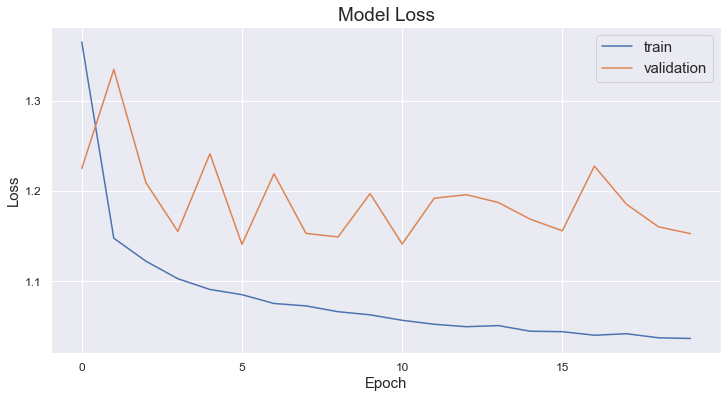

In [610]:
print(history.history.keys())
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontsize=19)
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(['train', 'validation'], fontsize=15, loc='best')
plt.show()

Adding hidden layers and dropout layers doesn't increase accuracy of the model. 

### Summary

My models performed very well and similarly. The second model performed the best. Using the best model, a clothing e-commerce can help customers choose best clothing size by asking for their body measurements to increase business sales, customer loyalty and cut down on costs. 

For future work, I would use other parameters in my model to evaluate the performances. For example, instead of using relu for the activation, I would use linear. Additionally, I would take more time to study and understand exisiting recommendation systems to understand how I could improve my model's performance even more. 